# Has increasing the number of Best Picture nominees from 5 to 10 increased viewership? What has the change done to the types of films that are nominated?

### Table of Contents

* [Introduction](#goals)
* [Data](#Data)
    * [Loading the Data](#section1_1)
    * [Data Information](#section1_2)
* [Data Cleaning](#cleaning)
* [Data Merging](#merging)
* [Exploratory Data Analysis](#EDA)
    * [Viewership Over Time](#section3_1)
    * [Oscars vs Average Decline](#section3_2)
    * [EDA Impressions - TV Viewership](#section3_3)
    * [Best Picture Nominee Box Office](#section3_4)
* [Relationship between Nominee Box Office and TV Viewership](#section4)
* [Conclusion](#conclusion)
    * [Next Steps](#next)

### Introduction<a class="anchor" id="Introduction"></a>

Beginning with the 82nd Academy Awards in 2010, the Academy of Motion Picture Arts and Sciences increased the number of Best Picture nominees from 5 to 10 (the following year, they slightly modified the procedure to allow *up to* 10 nominees, provided they received at least 5% support; for the 2022 awards they reverted back to the original design with exactly 10 nominees).

While the [official press release](https://www.indiewire.com/news/general-news/ampas-to-nominate-10-for-best-picture-70253/) noted that the move was to harken back to the first decades of the Oscars, which featured more Best Picture nominees, and said there were too many artistic achievements to warrant just 5 nominees, [many](https://www.latimes.com/archives/la-xpm-2010-feb-03-la-et-oscars-main3-2010feb03-story.html) at the [time](https://www.boxofficemojo.com/article/ed2373583876/) ([and](https://www.nytimes.com/2020/01/22/movies/expanded-best-picture-oscar.html) [since](https://www.polygon.com/2018/7/18/17585878/dark-knight-oscars-best-picture)) have described the move as a play for more viewers by enabling more popular films to earn a Best Picture nomination. After the failure of commercial and critical hits *WALL-E* and especially *The Dark Knight* did not receive Best Picture nominations, the conventional wisdom goes, the Academy increased the number of nominations to ensure something like that did not happen again. Part of this conventional wisdom is that more people will watch the awards show if big box office hits are up for the biggest award. In the 15 years since, there has been much debate about whether and how the Academy should try to appeal to a wider audience.

So, I am going to look at the data behind some of these decisions and debates. Did increasing the number of nominees actually improve viewership? Do Best Picture-nominated blockbusters lead to larger audiences? What are the typical nominees like before/after the change?

**Note: Referring to awards can sometimes get confusing depending on whether we are talking about the *movies released* in year X or the *awards show* held in year X for the movies of year X-1. To avoid confusion, I will try to always make clear whether I'm referring to the film's year or the ceremony's year.**

### Data<a class="anchor" id="Data"></a>

The data for this project were compiled from several sources. Kaggle provided the [Oscars data](https://www.kaggle.com/datasets/unanimad/the-oscar-award/) (originally retrieved from the Academy website awards archive) and [box office data](https://www.kaggle.com/datasets/jonbown/worldwide-box-office-rankings-1977) (originally taken from Box Office Mojo), while the viewership numbers were compiled from many different sources, including Nielsen archives, *USA Today* archives, Wikipedia, and other contemporaneous reporting.

The Oscars data has the nominees and winners of every category for every year; however, I am going to restrict my analysis to the 15 years since the Best Picture nominations change and the 15 years immediately preceding the change (this means the film years 1994-2023 or Oscars held in 1995-2024). This makes comparisons and finding good TV ratings data easier.

The Box Office data includes the total domestic (U.S., Canada, and Puerto Rico) and foreign (everywhere else) gross for the top 200 films of each year (only the box office earned for initial releases), which I will link to the Oscar nominees.

The TV ratings data includes the number of viewers of various awards shows, the Super Bowl, and the most watched TV program on average for each year in consideration for this analysis. I will use the viewership of other programs to compare to the Oscars audience. The Emmys and the CMAs are held in the fall, while the rest of the awards shows are held throughout the spring. TV seasons runs fall to spring, so the top TV program for a listed year is actually the top program for the fall of the previous year through the spring of the listed year. Since the 2024 Nielsen season-long data is currently not available, only the top TV programs up to the 2022-2023 season are included.

#### Loading the data<a class="anchor" id="section1_1"></a>

In [1]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
oscars_data = pd.read_csv('the_oscar_award.csv')
ratings_data = pd.read_csv('TVRatings.csv')

# need to read in different csv for each year
# need to add a 'year' column for each
box_office_data_list = []
for year in range(1994, 2024):
    df_tmp = pd.read_csv('BoxOffice/ranking_summary_{}.csv'.format(year))
    df_tmp['year'] = year
    box_office_data_list.append(df_tmp)
box_office_data = pd.concat(box_office_data_list)

In [224]:
box_office_data.reset_index(drop=True, inplace=True)

In [3]:
oscars_data_slim = oscars_data[oscars_data.year_ceremony >= 1995]
oscars_data_slim = oscars_data_slim[oscars_data_slim.category == "BEST PICTURE"]
oscars_data_slim.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
7398,1994,1995,67,BEST PICTURE,"Wendy Finerman, Steve Tisch and Steve Starkey,...",Forrest Gump,True
7399,1994,1995,67,BEST PICTURE,"Duncan Kenworthy, Producer",Four Weddings and a Funeral,False
7400,1994,1995,67,BEST PICTURE,"Lawrence Bender, Producer",Pulp Fiction,False
7401,1994,1995,67,BEST PICTURE,"Robert Redford, Michael Jacobs, Julian Krainin...",Quiz Show,False
7402,1994,1995,67,BEST PICTURE,"Niki Marvin, Producer",The Shawshank Redemption,False


In [4]:
oscars_data_slim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, 7398 to 10849
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      211 non-null    int64 
 1   year_ceremony  211 non-null    int64 
 2   ceremony       211 non-null    int64 
 3   category       211 non-null    object
 4   name           211 non-null    object
 5   film           211 non-null    object
 6   winner         211 non-null    bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 11.7+ KB


In [5]:
oscars_data_slim.groupby('year_film').count()

,year_ceremony,ceremony,category,name,film,winner
year_film,,,,,,
1994,5,5,5,5,5,5
1995,5,5,5,5,5,5
1996,5,5,5,5,5,5
1997,5,5,5,5,5,5
1998,5,5,5,5,5,5
1999,5,5,5,5,5,5
2000,5,5,5,5,5,5
2001,5,5,5,5,5,5
2002,5,5,5,5,5,5


In [6]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     209 non-null    int64  
 1   Show     209 non-null    object 
 2   Viewers  209 non-null    int64  
 3   Rating   60 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.7+ KB


In [7]:
ratings_data.head()

,Year,Show,Viewers,Rating
0,1995,67th Oscars,48279000,32.5
1,1996,68th Oscars,44867000,30.3
2,1997,69th Oscars,40075000,27.4
3,1998,70th Oscars,55249000,34.9
4,1999,71st Oscars,45615000,28.6


In [8]:
ratings_data.Show.unique()

array(['67th Oscars', '68th Oscars', '69th Oscars', '70th Oscars',
       '71st Oscars', '72nd Oscars', '73rd Oscars', '74th Oscars',
       '75th Oscars', '76th Oscars', '77th Oscars', '78th Oscars',
       '79th Oscars', '80th Oscars', '81st Oscars', '82nd Oscars',
       '83rd Oscars', '84th Oscars', '85th Oscars', '86th Oscars',
       '87th Oscars', '88th Oscars', '89th Oscars', '90th Oscars',
       '91st Oscars', '92nd Oscars', '93rd Oscars', '94th Oscars',
       '95th Oscars', '96th Oscars', 'Seinfeld', 'ER',
       'Who Wants to Be a Millionaire', 'Survivor', 'Friends',
       'CSI: Crime Scene Investigation', 'American Idol',
       'NBC Sunday Night Football', 'NCIS', 'The Big Bang Theory',
       'Roseanne', 'Super Bowl XXIX', 'Super Bowl XXX', 'Super Bowl XXXI',
       'Super Bowl XXXII', 'Super Bowl XXXIII', 'Super Bowl XXXIV',
       'Super Bowl XXXV', 'Super Bowl XXXVI', 'Super Bowl XXXVII',
       'Super Bowl XXXVIII', 'Super Bowl XXXIX', 'Super Bowl XL',
       'Supe

In [9]:
ratings_data.Year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 1994])

In [226]:
box_office_data.head(10)

,rank,title,worldwide,domestic,domestic_pct,foreign,foreign_pct,year
0,1,The Lion King,763455561.0,312855561.0,40.978883,450600000.0,59.021117,1994
1,2,Forrest Gump,329694514.0,329694499.0,99.999995,0.0,0.000000,1994
2,3,True Lies,146282411.0,146282411.0,100.000000,0.0,0.000000,1994
3,4,The Santa Clause,144833964.0,144833357.0,99.999581,165.0,0.000114,1994
4,5,The Flintstones,130531208.0,130531208.0,100.000000,0.0,0.000000,1994
5,6,Dumb and Dumber,127175668.0,127175374.0,99.999769,294.0,0.000231,1994
6,7,Clear and Present Danger,122187717.0,122187717.0,100.000000,0.0,0.000000,1994
7,8,Speed,121248452.0,121248145.0,99.999747,0.0,0.000000,1994
8,9,The Mask,119938730.0,119938730.0,100.000000,0.0,0.000000,1994
9,10,Pulp Fiction,107964120.0,107928762.0,99.967250,35358.0,0.032750,1994


In [227]:
box_office_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          6000 non-null   int64  
 1   title         6000 non-null   object 
 2   worldwide     6000 non-null   float64
 3   domestic      6000 non-null   float64
 4   domestic_pct  6000 non-null   float64
 5   foreign       6000 non-null   float64
 6   foreign_pct   6000 non-null   float64
 7   year          6000 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 375.1+ KB


#### Data Information <a class="anchor" id="section1_2"></a>

Oscars data:
* 211 total nominees from ceremony years 1995-2024
* 5 nominees per ceremony from 1995-2009, 10 for 2010 and 2011, 8 or 9 from 2012-2021, and 10 again for 2022-2024.

Ratings data:
* 209 rows for programs from 1994-2024
* Categories: Oscars, Grammys, Golden Globes, Emmys, CMAs, Super Bowl, Top TV Program (will need to add this as a column to make analysis easier)
* Viewers available for every row, but Rating only available for some, so the analysis will use total number of viewers instead of rating (which measures a percentage of households)

Box office data:
* 30 years (1995-2024) * 200 films per year = 6000 entries
* Cleaning needed for some of the columns

### Data Cleaning<a class="anchor" id="cleaning"></a>

The box office data has '-' to indicate 0 domestic or foreign box office, so I will replace those entries with zeros. Additionally, I will remove the '$' so I can convert all the relevant columns to numeric data types. The domestic and foreign percentage columns also need to have '-' replaced as 0 and the '\%' removed. But there are some values also written as '<0.1\%' . I will actually just calculate all the percentages myself and replace the columns.

In [12]:
box_office_data[['worldwide','domestic','foreign']] = box_office_data[['worldwide','domestic','foreign']].replace('-', '0', regex=True)
box_office_data[['worldwide','domestic','foreign']] = box_office_data[['worldwide','domestic','foreign']].replace('[\$,]', '', regex=True).astype(float)

In [228]:
box_office_data.tail(10)

,rank,title,worldwide,domestic,domestic_pct,foreign,foreign_pct,year
5990,191,All Your Faces,9056053.0,0.0,0.000000,9056053.0,100.000000,2023
5991,192,The Animal Kingdom,8934193.0,7173.0,0.080287,8927020.0,99.919713,2023
5992,193,The Wandering Earth II,8854786.0,5023132.0,56.727876,3831654.0,43.272124,2023
5993,194,Cats in the Museum,8682452.0,0.0,0.000000,8682452.0,100.000000,2023
5994,195,Father & Soldier,8598322.0,0.0,0.000000,8598322.0,100.000000,2023
5995,196,PreCure All Stars F,8519569.0,0.0,0.000000,8519569.0,100.000000,2023
5996,197,The Great Escaper,8391332.0,0.0,0.000000,8391332.0,100.000000,2023
5997,198,Dream,8317251.0,0.0,0.000000,8317251.0,100.000000,2023
5998,199,Vacaciones de verano,8209854.0,0.0,0.000000,8209854.0,100.000000,2023
5999,200,Weekend Rebels,8184539.0,0.0,0.000000,8184539.0,100.000000,2023


In [229]:
box_office_data['domestic_pct'] = box_office_data['domestic'] / box_office_data['worldwide'] * 100
box_office_data['foreign_pct'] = box_office_data['foreign'] / box_office_data['worldwide'] * 100
box_office_data.head(10)

,rank,title,worldwide,domestic,domestic_pct,foreign,foreign_pct,year
0,1,The Lion King,763455561.0,312855561.0,40.978883,450600000.0,59.021117,1994
1,2,Forrest Gump,329694514.0,329694499.0,99.999995,0.0,0.000000,1994
2,3,True Lies,146282411.0,146282411.0,100.000000,0.0,0.000000,1994
3,4,The Santa Clause,144833964.0,144833357.0,99.999581,165.0,0.000114,1994
4,5,The Flintstones,130531208.0,130531208.0,100.000000,0.0,0.000000,1994
5,6,Dumb and Dumber,127175668.0,127175374.0,99.999769,294.0,0.000231,1994
6,7,Clear and Present Danger,122187717.0,122187717.0,100.000000,0.0,0.000000,1994
7,8,Speed,121248452.0,121248145.0,99.999747,0.0,0.000000,1994
8,9,The Mask,119938730.0,119938730.0,100.000000,0.0,0.000000,1994
9,10,Pulp Fiction,107964120.0,107928762.0,99.967250,35358.0,0.032750,1994


<IPython.core.display.Javascript object>


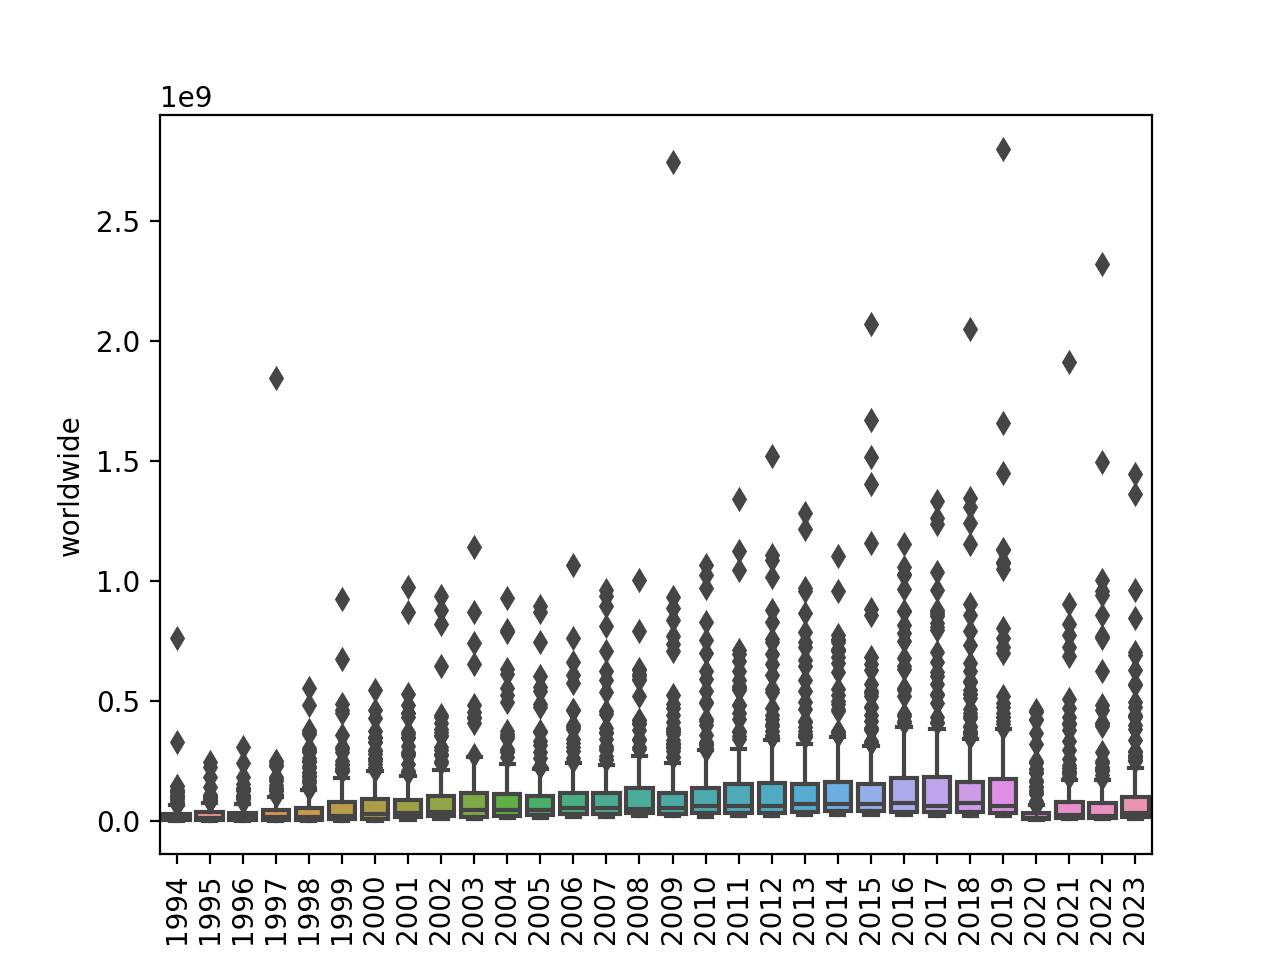

In [230]:
plt.figure()
sns.boxplot(x = box_office_data["year"], y = box_office_data["worldwide"])
plt.xticks(rotation=90)
plt.show()

<IPython.core.display.Javascript object>


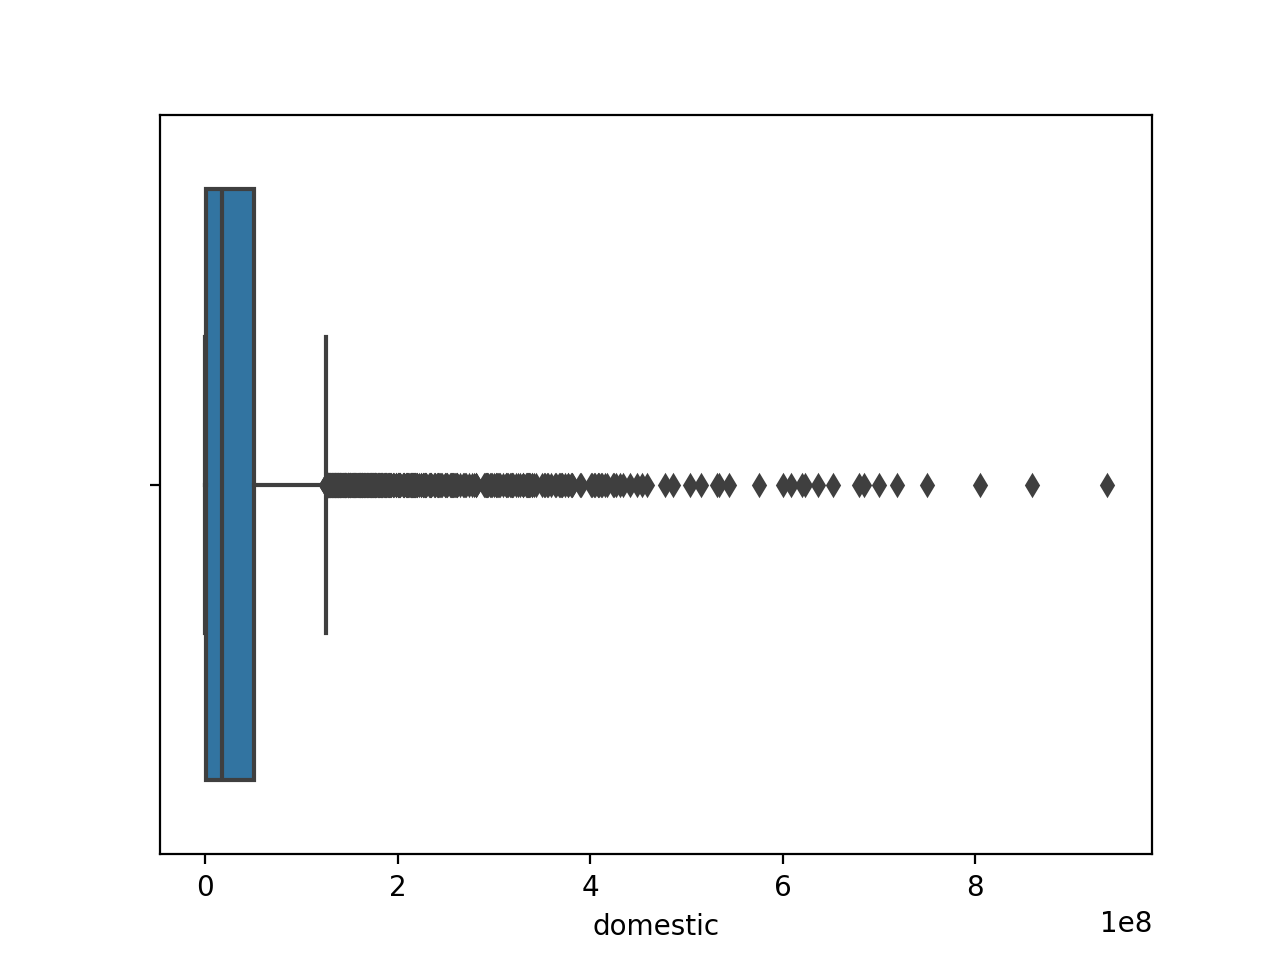

In [231]:
plt.figure()
sns.boxplot(x = box_office_data["domestic"])
plt.show()

I will now add a column to the TV ratings dataframe to help with analysis by categorizing each entry based on which awards show/Super Bowl/weekly program category it belongs to.

In [17]:
categories = ['Oscars', 'Grammys', 'Golden Globes', 'Emmys', 'CMAs', 'Super Bowl']

def ratings_categories(row):
    for category in categories:
        if category in row:
            return category
    return 'Top Program'

ratings_data['Category'] = ratings_data['Show'].apply(ratings_categories)
ratings_data.head()

,Year,Show,Viewers,Rating,Category
0,1995,67th Oscars,48279000,32.5,Oscars
1,1996,68th Oscars,44867000,30.3,Oscars
2,1997,69th Oscars,40075000,27.4,Oscars
3,1998,70th Oscars,55249000,34.9,Oscars
4,1999,71st Oscars,45615000,28.6,Oscars


In [18]:
ratings_data.groupby('Category').count()

,Year,Show,Viewers,Rating
Category,,,,
CMAs,30,30,30,0
Emmys,30,30,30,0
Golden Globes,30,30,30,0
Grammys,30,30,30,0
Oscars,30,30,30,30
Super Bowl,30,30,30,30
Top Program,29,29,29,0


### Data Merging<a class="anchor" id="merging"></a>

I will now merge the Oscars and box office data in order to link the nominees listed in one dataframe to their box office numbers in another dataframe.

In [232]:
oscars_box_office = pd.merge(oscars_data_slim, box_office_data, how='left', left_on='film', right_on='title')

In [233]:
oscars_box_office = oscars_box_office[['year_film','year_ceremony','category','film','winner','rank','worldwide','domestic','foreign','domestic_pct','foreign_pct']]
oscars_box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_film      216 non-null    int64  
 1   year_ceremony  216 non-null    int64  
 2   category       216 non-null    object 
 3   film           216 non-null    object 
 4   winner         216 non-null    bool   
 5   rank           199 non-null    float64
 6   worldwide      199 non-null    float64
 7   domestic       199 non-null    float64
 8   foreign        199 non-null    float64
 9   domestic_pct   199 non-null    float64
 10  foreign_pct    199 non-null    float64
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 17.2+ KB


In [234]:
oscars_box_office[oscars_box_office.worldwide.isna()]

,year_film,year_ceremony,category,film,winner,rank,worldwide,domestic,foreign,domestic_pct,foreign_pct
8,1995,1996,BEST PICTURE,The Postman (Il Postino),False,NaN,NaN,NaN,NaN,NaN,NaN
40,2001,2002,BEST PICTURE,Moulin Rouge,False,NaN,NaN,NaN,NaN,NaN,NaN
83,2009,2010,BEST PICTURE,Precious: Based on the Novel 'Push' by Sapphire,False,NaN,NaN,NaN,NaN,NaN,NaN
96,2010,2011,BEST PICTURE,Winter's Bone,False,NaN,NaN,NaN,NaN,NaN,NaN
159,2017,2018,BEST PICTURE,"Three Billboards outside Ebbing, Missouri",False,NaN,NaN,NaN,NaN,NaN,NaN
165,2018,2019,BEST PICTURE,Roma,False,NaN,NaN,NaN,NaN,NaN,NaN
169,2019,2020,BEST PICTURE,The Irishman,False,NaN,NaN,NaN,NaN,NaN,NaN
174,2019,2020,BEST PICTURE,Marriage Story,False,NaN,NaN,NaN,NaN,NaN,NaN
176,2019,2020,BEST PICTURE,Once upon a Time...in Hollywood,False,NaN,NaN,NaN,NaN,NaN,NaN
180,2020,2021,BEST PICTURE,Mank,False,NaN,NaN,NaN,NaN,NaN,NaN


There are a few categories of missing data:
* Title mismatches:
    * The Oscars list the 1995 film as "The Postman (Il Postino)" while Box Office Mojo calls the same film "The Postman"
    * "Moulin Rouge" vs "Moulin Rouge!"
    * "Precious: Based on the Novel 'Push' by Sapphire" vs "Precious"
    * "Three Billboards outside Ebbing, Missouri" vs "Three Billboards Outside Ebbing, Missouri
    * "Once upon a Time...in Hollywood" vs "Once Upon a Time... in Hollywood"
* Not in the top 200:
    * Winter's Bone
* Streaming Releases
    * Roma
    * The Irishman
    * Marriage Story
    * Mank
    * Sound of Metal
    * The Trial of the Chicago 7
    * CODA
    * Don't Look Up
    * The Power of the Dog
    * Maestro

The first two categories I will just fix by hand given that there's a small number of them. The third category is much trickier. Since there is no way of comparing these streaming films to theatrical films, I will remove them from the pool entirely. There's no real box office information for them that would make sense to include, because even if they had very short eligibility-related relases in New York or Los Angeles, that does not actually indicate their popularity. This is a potential pitfall of this analysis given the rise of streaming since the rule change. But for now I will go forward, removing these films and trying to continue on nevertheless.

In [236]:
edit_list = ['The Postman','Precious','Three Billboards Outside Ebbing, Missouri',
            'Once Upon a Time... in Hollywood','Moulin Rouge!']
box_office_data[box_office_data.title.isin(edit_list)]

,rank,title,worldwide,domestic,domestic_pct,foreign,foreign_pct,year
276,77,The Postman,21848932.0,21848932.0,100.000000,0.0,0.000000,1995
692,93,The Postman,17626234.0,17626234.0,100.000000,0.0,0.000000,1997
1422,23,Moulin Rouge!,179213434.0,57386607.0,32.021376,121826827.0,67.978624,2001
3085,86,Precious,63649529.0,47566524.0,74.731934,16083005.0,25.268066,2009
4656,57,"Three Billboards Outside Ebbing, Missouri",160060063.0,54513740.0,34.058302,105546323.0,65.941698,2017
5023,24,Once Upon a Time... in Hollywood,377426903.0,142502728.0,37.756378,234924175.0,62.243622,2019


In [239]:
box_office_data.at[276, 'title'] = 'The Postman (Il Postino)'
box_office_data.at[1422, 'title'] = 'Moulin Rouge'
box_office_data.at[3085, 'title'] = "Precious: Based on the Novel 'Push' by Sapphire"
box_office_data.at[4656, 'title'] = 'Three Billboards outside Ebbing, Missouri'
box_office_data.at[5023, 'title'] = 'Once upon a Time...in Hollywood'

In [241]:
oscars_box_office = pd.merge(oscars_data_slim, box_office_data, how='left', left_on='film', right_on='title')
oscars_box_office = oscars_box_office[['year_film','year_ceremony','category','film','winner','rank','worldwide','domestic','foreign','domestic_pct','foreign_pct']]
oscars_box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_film      216 non-null    int64  
 1   year_ceremony  216 non-null    int64  
 2   category       216 non-null    object 
 3   film           216 non-null    object 
 4   winner         216 non-null    bool   
 5   rank           204 non-null    float64
 6   worldwide      204 non-null    float64
 7   domestic       204 non-null    float64
 8   foreign        204 non-null    float64
 9   domestic_pct   204 non-null    float64
 10  foreign_pct    204 non-null    float64
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 17.2+ KB


In [248]:
edit_values = {'worldwide': 13796834, 'domestic': 6531503, 'foreign': 7265331, 
               'domestic_pct': 6531503/13796834*100, 'foreign_pct': 7265331/13796834*100}
oscars_box_office.loc[96, ['worldwide', 'domestic', 'foreign', 'domestic_pct', 'foreign_pct']] = edit_values.values()
oscars_box_office.loc[96]

year_film                 2010
year_ceremony             2011
category          BEST PICTURE
film             Winter's Bone
winner                   False
rank                       NaN
worldwide           13796834.0
domestic             6531503.0
foreign              7265331.0
domestic_pct         47.340593
foreign_pct          52.659407
Name: 96, dtype: object

In [250]:
oscars_box_office = oscars_box_office.dropna(subset=['worldwide'])
oscars_box_office.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 215
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_film      205 non-null    int64  
 1   year_ceremony  205 non-null    int64  
 2   category       205 non-null    object 
 3   film           205 non-null    object 
 4   winner         205 non-null    bool   
 5   rank           204 non-null    float64
 6   worldwide      205 non-null    float64
 7   domestic       205 non-null    float64
 8   foreign        205 non-null    float64
 9   domestic_pct   205 non-null    float64
 10  foreign_pct    205 non-null    float64
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 17.8+ KB


In [262]:
oscars_box_office[oscars_box_office['rank'].isna()]

,year_film,year_ceremony,category,film,winner,rank,worldwide,domestic,foreign,domestic_pct,foreign_pct
96,2010,2011,BEST PICTURE,Winter's Bone,False,NaN,13796834.0,6531503.0,7265331.0,47.340593,52.659407


I've removed the issues; now the only NaN value remaining is the rank for Winter's Bone which isn't available to me at the moment because it's outside the top 200. The streaming-released films have been removed. Now I can continue to the analysis.

### Exploratory Data Analysis <a class="anchor" id="EDA"></a>

I will now begin analyzing the data, beginning with exploring the TV ratings of the Oscars over time. I will look at how they compare to other program ratings. I will also look at any changes from the 2009 to 2010 awards or the periods before/after the nomination change of interest.

#### Viewership time series<a class="anchor" id="section3_1"></a>

<IPython.core.display.Javascript object>


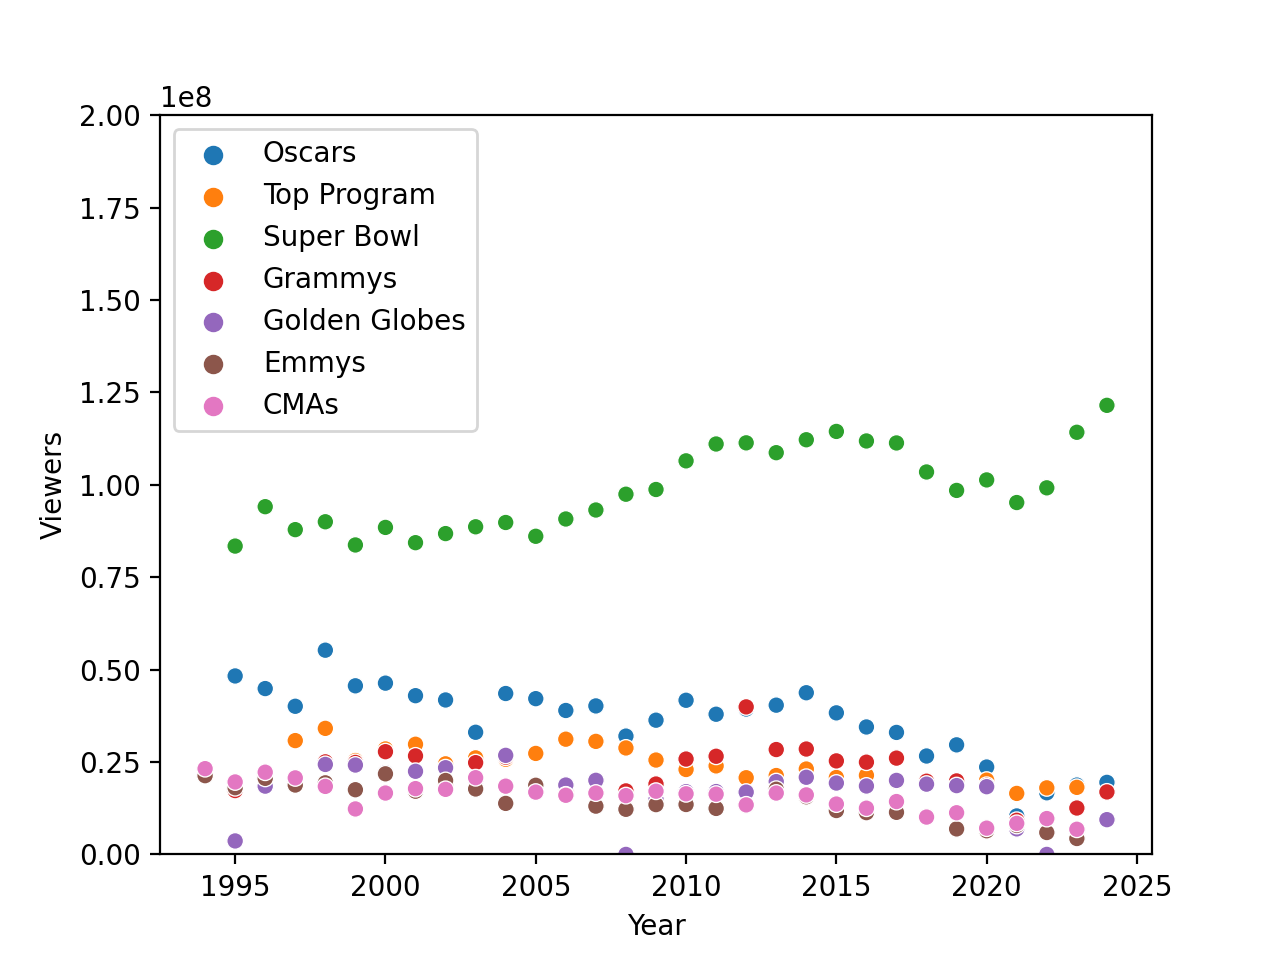

In [19]:
plt.figure()
sns.scatterplot(x = 'Year', y = 'Viewers', hue = 'Category', 
                data = ratings_data)
plt.ylim(0,2e8)
plt.legend(loc='upper left')
plt.show()

In the Grammys data there is a clear spike in 2012. Viewership increased by over 50% for that year's show, which occurred the day after Whitney Houston died and featured a tributes to her including a performance by Jennifer Hudson. The shocking news is cited as the reason for the large increase.

There are three points to note in the Golden Globes viewership data. The first year of this dataset for the Golden Globes, 1995, was the final year the Globes were telecast on TBS before moving to NBC (as of 2024 they are on CBS/Paramount+). The ratings experience a huge boost from 3.64 million viewers to 18.47 million viewers when they moved to NBC. Additionally, the ratings are 0 for 2008 and 2022. In 2008, the awards were scheduled during the WGA writers' strike so were announced via a press conference instead of a televised show. In 2022, the Hollywood Foreign Press Association, the body who awards the Golden Globes, faced backlash and boycotts over their lack of diversity and inclusion, so the awards were announced at a private event that was not televised.

For this, I think it's better to remove these points rather than run the risk of analyzing the data as if they aired a show that had 0 viewers. The 1995 point could be included, but the rest of the points are for shows on network television and it's a more apples-to-apples comparison without this one point for the Globes.

In [20]:
mask = (ratings_data['Category'] == 'Golden Globes') & (ratings_data['Year'].isin([1995, 2008, 2022]))
ratings_data = ratings_data[~mask]

In [21]:
ratings_data.groupby('Category').count()

,Year,Show,Viewers,Rating
Category,,,,
CMAs,30,30,30,0
Emmys,30,30,30,0
Golden Globes,27,27,27,0
Grammys,30,30,30,0
Oscars,30,30,30,30
Super Bowl,30,30,30,30
Top Program,29,29,29,0


To clean up the overlapping points for all the non-Super Bowl events, I will plot a subset of the categories.

<IPython.core.display.Javascript object>


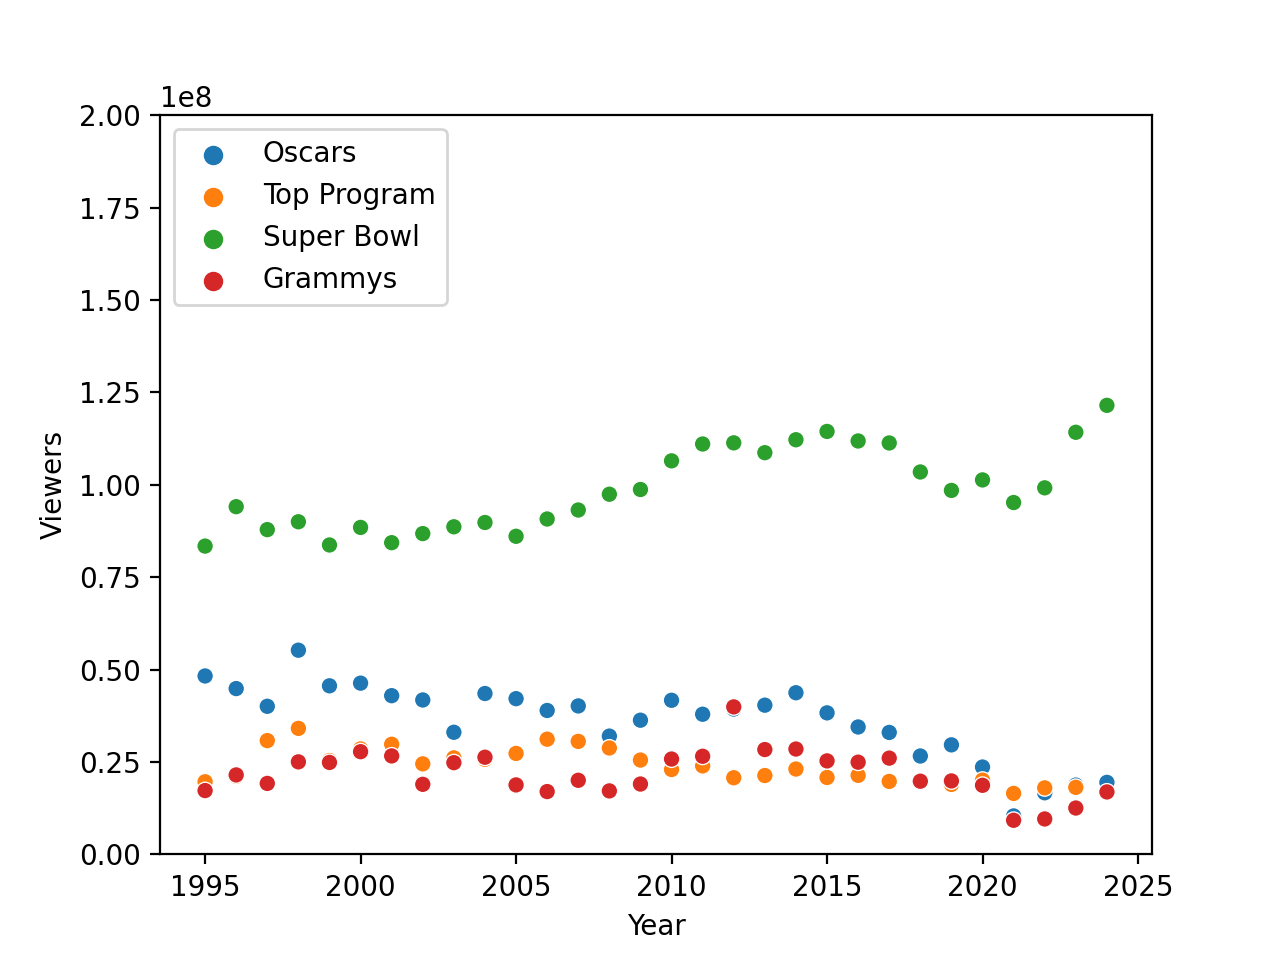

In [22]:
plt.figure()
sns.scatterplot(x = 'Year', y = 'Viewers', hue = 'Category', 
                data = ratings_data[ratings_data.Category.isin(['Oscars','Top Program','Super Bowl','Grammys'])])
plt.ylim(0,2e8)
plt.legend(loc='upper left')
plt.show()

The top program of each season seems to be holding pretty steady over these years, while the Super Bowl is increasing in viewership. (As the population has increased drastically since 1995, holding steady means a net decrease in share of households watching the program.)

One other way to look at this data is in terms of growth/loss by comparing to initial values. Since the Golden Globes data point for 1995 is gone, I will treat 1996 as a baseline and compute percentages relative to that 1996 baseline.

In [23]:
initial_values = ratings_data[ratings_data.Year == 1996]
initial_values = initial_values[['Viewers','Category']]
initial_values

,Viewers,Category
1,44867000,Oscars
31,21100000,Top Program
60,94080000,Super Bowl
90,21500000,Grammys
120,18470000,Golden Globes
150,20580000,Emmys
205,22240000,CMAs


In [24]:
def get_baseline(row):
    mask = (initial_values.Category == row.Category)
    return initial_values[mask].Viewers.values[0]
ratings_data['Baseline'] = ratings_data.apply(lambda x: get_baseline(x), axis=1)
ratings_data

,Year,Show,Viewers,Rating,Category,Baseline
0,1995,67th Oscars,48279000,32.5,Oscars,44867000
1,1996,68th Oscars,44867000,30.3,Oscars,44867000
2,1997,69th Oscars,40075000,27.4,Oscars,44867000
3,1998,70th Oscars,55249000,34.9,Oscars,44867000
4,1999,71st Oscars,45615000,28.6,Oscars,44867000
...,...,...,...,...,...,...
204,1997,31st CMAs,20700000,NaN,CMAs,22240000
205,1996,30th CMAs,22240000,NaN,CMAs,22240000
206,1995,29th CMAs,19600000,NaN,CMAs,22240000
207,1994,46th Emmys,21300000,NaN,Emmys,20580000


In [26]:
ratings_data['Ratio1996'] = ratings_data['Viewers'] / ratings_data['Baseline']
ratings_data.drop(columns=['Baseline'], inplace=True)
ratings_data

,Year,Show,Viewers,Rating,Category,Ratio1996
0,1995,67th Oscars,48279000,32.5,Oscars,1.076047
1,1996,68th Oscars,44867000,30.3,Oscars,1.000000
2,1997,69th Oscars,40075000,27.4,Oscars,0.893195
3,1998,70th Oscars,55249000,34.9,Oscars,1.231395
4,1999,71st Oscars,45615000,28.6,Oscars,1.016671
...,...,...,...,...,...,...
204,1997,31st CMAs,20700000,NaN,CMAs,0.930755
205,1996,30th CMAs,22240000,NaN,CMAs,1.000000
206,1995,29th CMAs,19600000,NaN,CMAs,0.881295
207,1994,46th Emmys,21300000,NaN,Emmys,1.034985


<IPython.core.display.Javascript object>


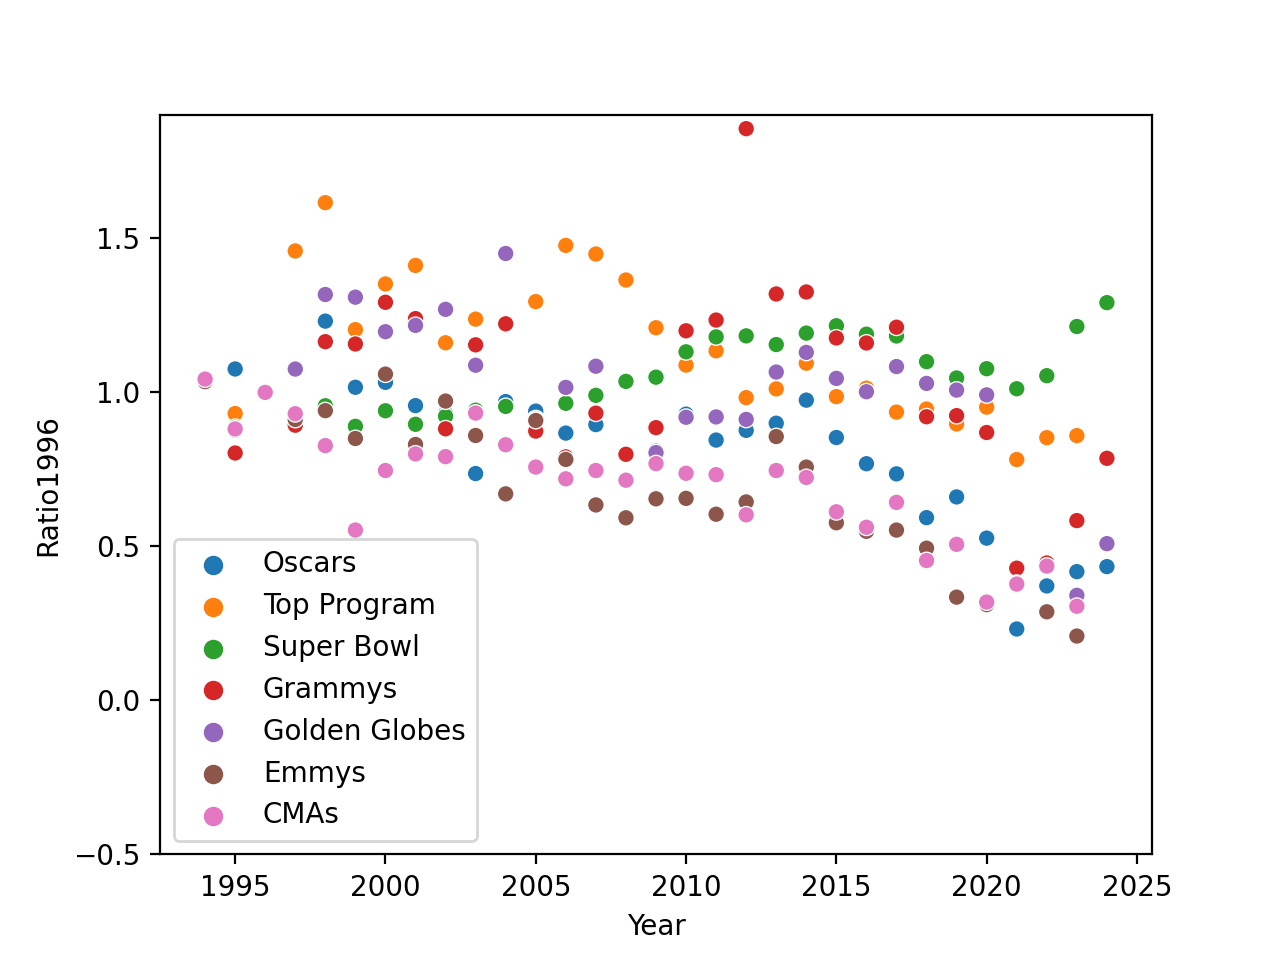

In [27]:
plt.figure()
sns.scatterplot(x = 'Year', y = 'Ratio1996', hue = 'Category', 
                data = ratings_data)
plt.ylim(-0.5,1.9)
plt.legend(loc='lower left')
plt.show()

Looking at the above plot, we can see the Oscars (blue), Emmys (brown) and CMAs (pink) tracking near each other. The Top Program (orange) was generally above its 1996 viewership over this entire range, but you can see it dipping from about 1.5 back down to about 1.0. The Super Bowl (green) is slightly increasing over this range. The Grammys (red) and Golden Globes (purple) had lots of points above 1.0 over lots of this time period.

The pandemic in 2020 was a clearly impactful period as seen on this graph. While the Super Bowl and the Top Program did not see a large effect, the awards shows all had very low figures for the first show in the pandemic (fall 2020 for CMAs and Emmys, spring 2021 for the rest). The numbers have been rising since then (though it remains to be seen where the fall 2024 CMAs and Emmys end up) but are still below pre-pandemic levels, which themselves were low compared to 1996 levels.

#### Comparing Oscars to Average Decline<a class="anchor" id="section3_2"></a>

Next, instead of looking at everything in terms of a baseline in one particular year, I will compare each year to the maximum ratings over this period. Maybe 1996 was a fluke year for one or more of these programs. So I will look at the ratio comparing to the peak viewership.

In [28]:
max_values = ratings_data.loc[ratings_data.groupby('Category').Viewers.idxmax(), ['Year','Category','Viewers']]
max_values

,Year,Category,Viewers
208,1994,CMAs,23200000
154,2000,Emmys,21800000
128,2004,Golden Globes,26800000
106,2012,Grammys,39910000
3,1998,Oscars,55249000
88,2024,Super Bowl,121500000
33,1998,Top Program,34100000


In [29]:
ratings_data['RatioMax'] = ratings_data.apply(lambda x: ratings_data[ratings_data.Category == x.Category].Viewers.max(), axis=1)
ratings_data['RatioMax'] = ratings_data['Viewers'] / ratings_data['RatioMax']
ratings_data

,Year,Show,Viewers,Rating,Category,Ratio1996,RatioMax
0,1995,67th Oscars,48279000,32.5,Oscars,1.076047,0.873844
1,1996,68th Oscars,44867000,30.3,Oscars,1.000000,0.812087
2,1997,69th Oscars,40075000,27.4,Oscars,0.893195,0.725352
3,1998,70th Oscars,55249000,34.9,Oscars,1.231395,1.000000
4,1999,71st Oscars,45615000,28.6,Oscars,1.016671,0.825626
...,...,...,...,...,...,...,...
204,1997,31st CMAs,20700000,NaN,CMAs,0.930755,0.892241
205,1996,30th CMAs,22240000,NaN,CMAs,1.000000,0.958621
206,1995,29th CMAs,19600000,NaN,CMAs,0.881295,0.844828
207,1994,46th Emmys,21300000,NaN,Emmys,1.034985,0.977064


<IPython.core.display.Javascript object>


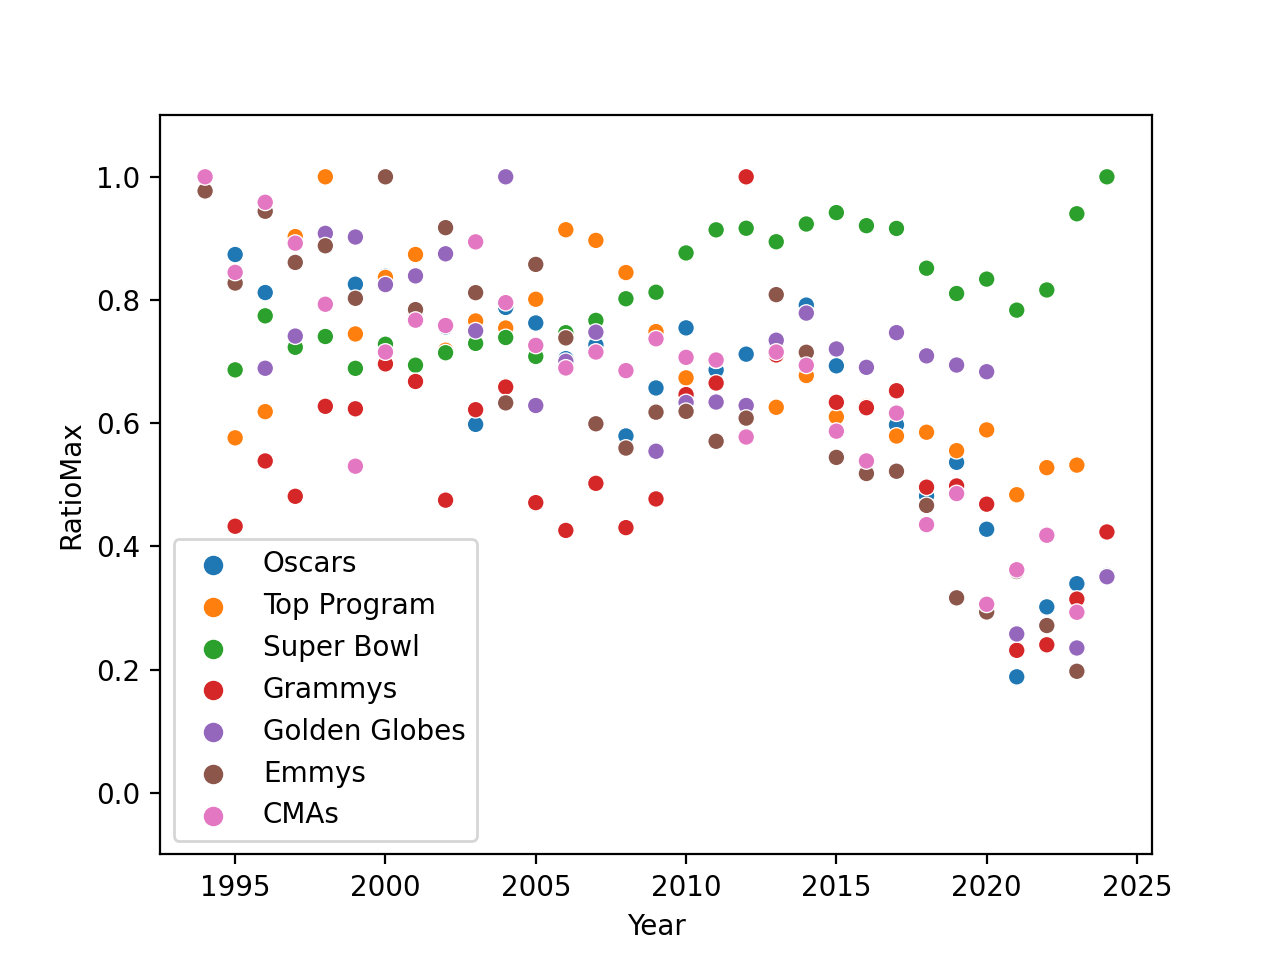

In [104]:
plt.figure()
sns.scatterplot(x = 'Year', y = 'RatioMax', hue = 'Category', 
                data = ratings_data)
plt.ylim(-0.1,1.1)
plt.legend(loc='lower left')
plt.show()

This view highlights when each program received its highest viewership (the one you cannot see is the Oscars reaching its maximum in 1998, hidden behind the Top Program point). Aside from the spike in the 2012 Grammys, the awards shows had their peaks in the 90s or early 2000s and have mostly been in decline since then.

In [105]:
def get_years_since_max(row):
    mask = (max_values.Category == row.Category)
    return row.Year - max_values[mask].Year.values[0]
ratings_data['YearSinceMax'] = ratings_data.apply(lambda x: get_years_since_max(x), axis=1)

<IPython.core.display.Javascript object>


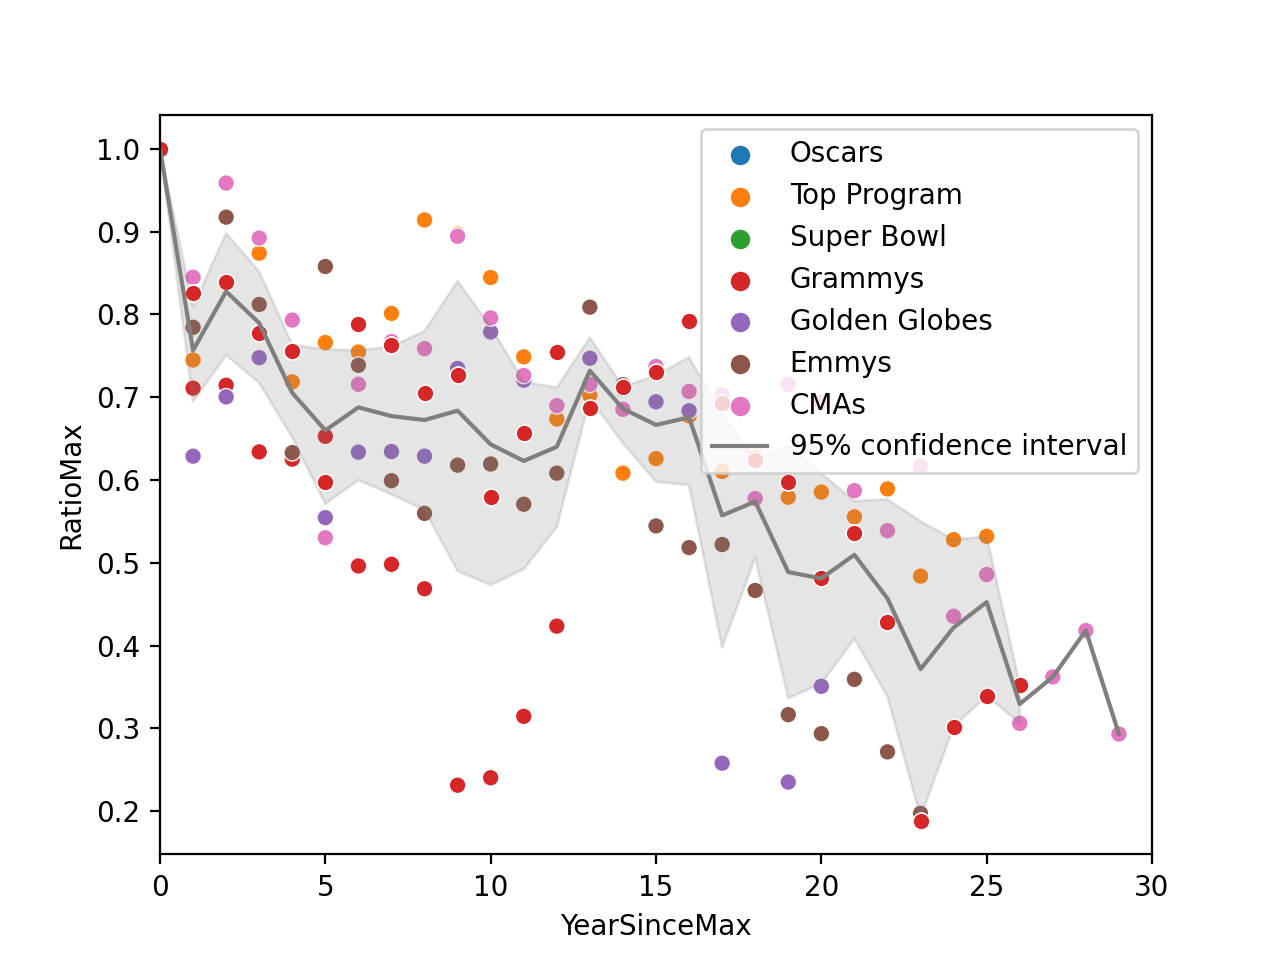

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [107]:
plt.figure()
sns.scatterplot(x = 'YearSinceMax', y = 'RatioMax', hue = 'Category', 
                data = ratings_data)
ax = plt.gca()
sns.lineplot(x = 'YearSinceMax', y = 'RatioMax', data = ratings_data, 
             ax=ax, label='95% confidence interval', color=sns.color_palette()[7])
line = plt.gca().lines[0]
line_xdata = line.get_xdata()
line_ydata = line.get_ydata()
plt.xlim(0,30)
plt.show()

In [119]:
oscars_xdata = ratings_data[ratings_data.Category=='Oscars'].YearSinceMax
oscars_ydata = ratings_data[ratings_data.Category=='Oscars'].RatioMax

<IPython.core.display.Javascript object>


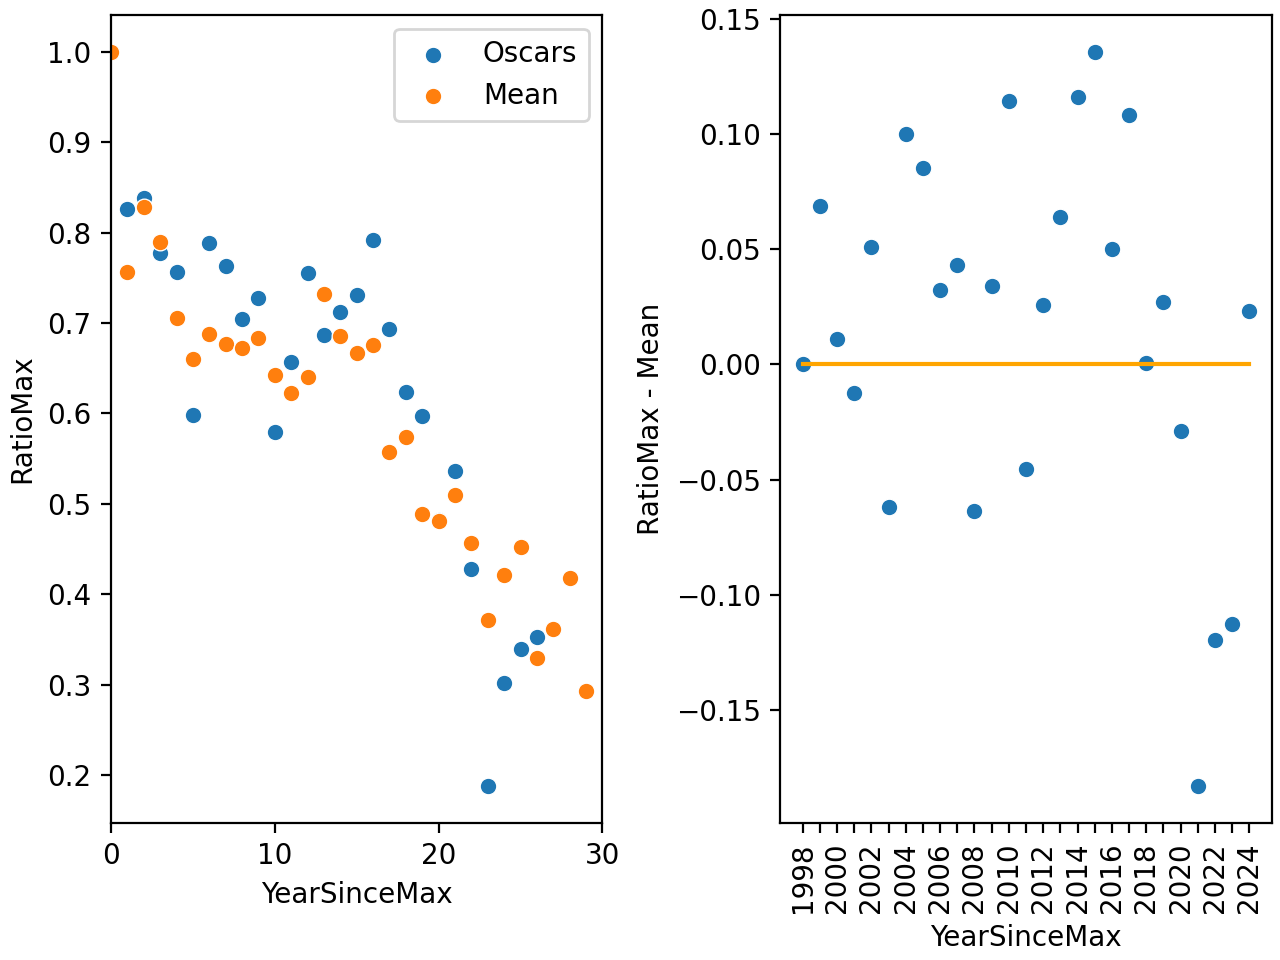

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
sns.scatterplot(x=oscars_xdata, y=oscars_ydata, ax=ax1, label='Oscars')
sns.scatterplot(x=line_xdata, y=line_ydata, ax=ax1, label='Mean')
ax1.legend()
ax1.set_xlim(0,30)
sns.scatterplot(x=oscars_xdata[3:], y=oscars_ydata[3:]-line_ydata[29:-3], ax=ax2)
plt.plot([0, 26], [0, 0], color='orange')
ax2.set_ylabel('RatioMax - Mean')
ax2.set_xticks(range(len(oscars_xdata[3:])), labels=[x+1998 for x in oscars_xdata[3:]])
ax2.tick_params(axis='x', labelrotation=90)
for label in ax2.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
#ax2.set_xlim(0,26)
plt.show()

The above plots show the viewership with the x-axis set to years since max viewership. Even though their peak popularities occur at different years, the shapes of the decline from their peaks is largely similar. The plot shows a shaded region with the mean and 95% confidence interval. The previous plot shows how the Oscars decline compares to the average. The right subplot shows the difference between the Oscars ratio to maximum viewers and the mean across all the programs. The Oscars are above 0 for most of this 26 year period since their maximum viewership, indicating that their decline has been on average better than the others (histogram of residual values below). Additionally, the three lowest points are for pandemic-era shows, which hit the Oscars quite hard compared to the mean behavior at that point in their decline.

<IPython.core.display.Javascript object>


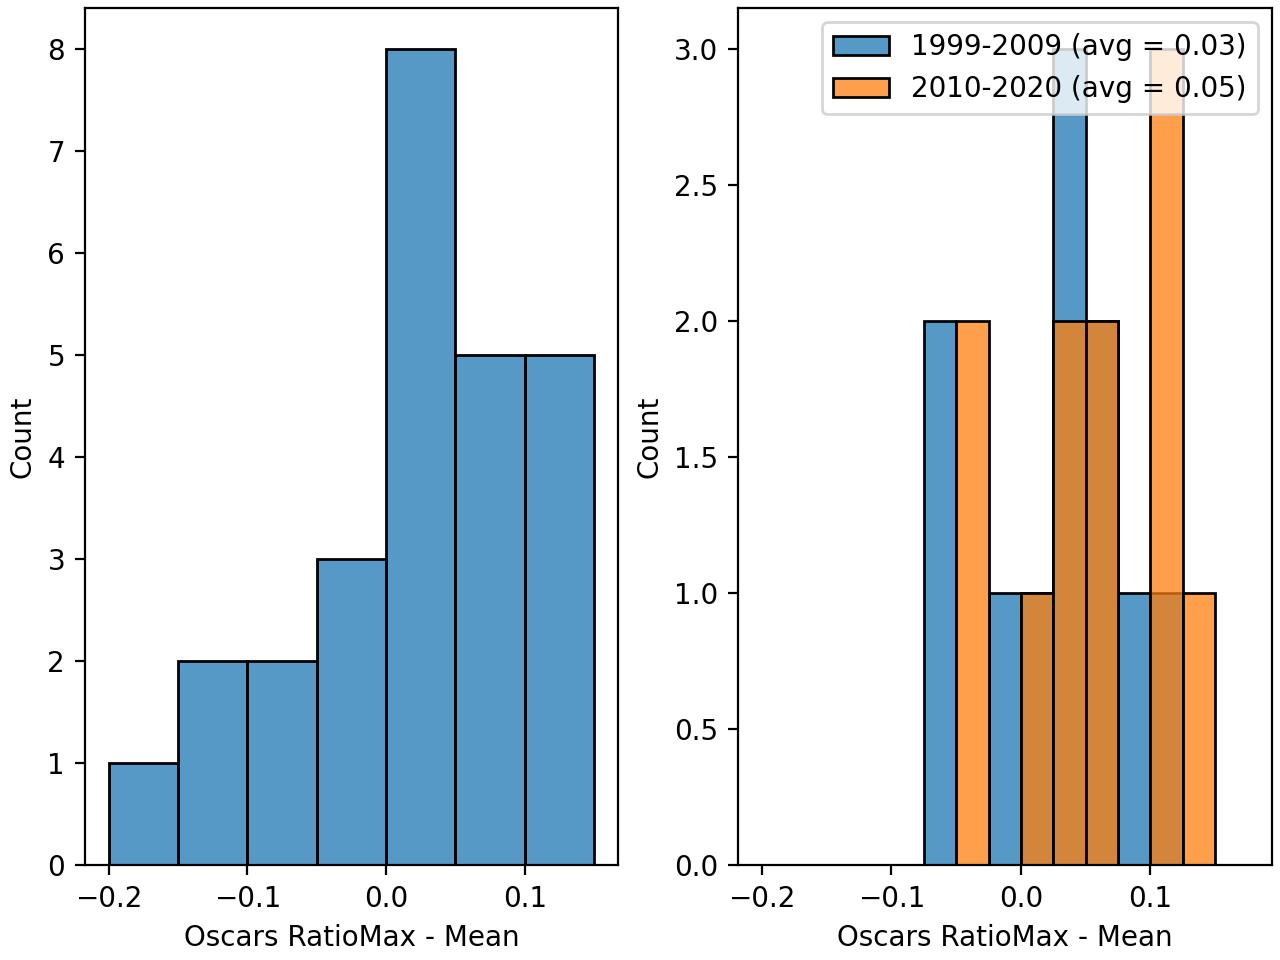

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
sns.histplot(oscars_ydata[4:]-line_ydata[30:-3], bins=np.arange(-0.2,0.2,0.05), ax=ax1)
ax1.set_xlabel('Oscars RatioMax - Mean')
sns.histplot(oscars_ydata[4:15]-line_ydata[30:-18], bins=np.arange(-0.2,0.2,0.025), 
             ax=ax2, label='1999-2009 (avg = {:.2f})'.format(np.mean(oscars_ydata[4:15]-line_ydata[30:-18])))
sns.histplot(oscars_ydata[15:-4]-line_ydata[-18:-7], bins=np.arange(-0.2,0.2,0.025), 
             ax=ax2, label='2010-2020 (avg = {:.2f})'.format(np.mean(oscars_ydata[15:-4]-line_ydata[-18:-7])))
ax2.legend()
ax2.set_xlabel('Oscars RatioMax - Mean')
plt.show()

The above histograms show that overall, the decline for the Oscars has been better than average. Splitting the period into the 1999-2009 period and the 2010-2020 (11 years before/after the rules change and not affected by the pandemic shows), we can see how the different rules periods compare. Since there are only 11 points for each, it's hard to compare and draw definite conclusions. In the pre-2010 period, there were 3 of 11 years with below average viewership. In the post-2010 period, there were 2. The mean of the post-2010 era is slightly higher than the pre-2010 era, but well within statistical fluctuation.

Finally for this initial set of graphs, I will look at the ratings (rather than viewers) that I was able to get for the Super Bowl and Oscars.

<IPython.core.display.Javascript object>


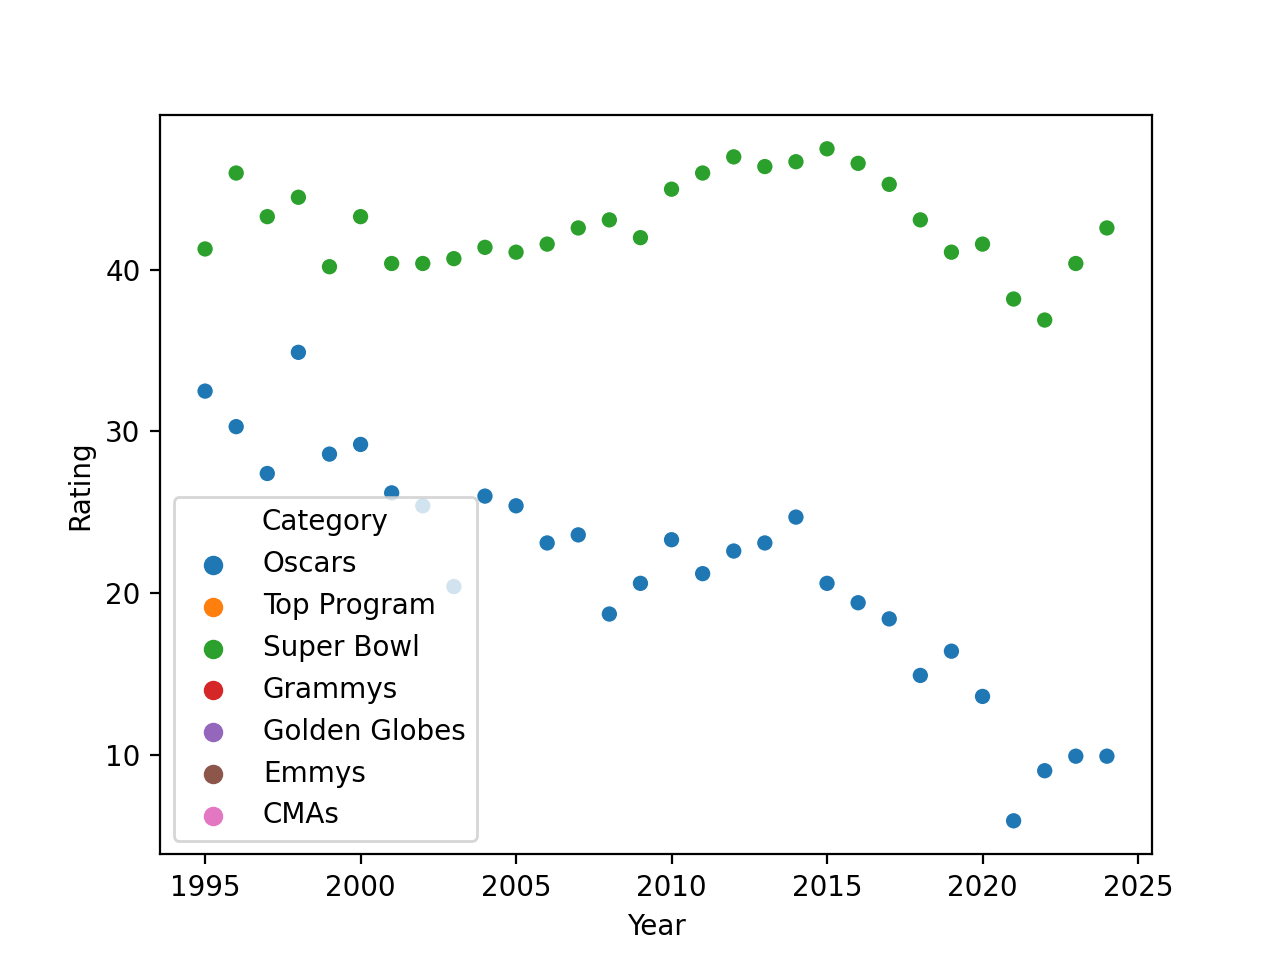

In [170]:
plt.figure()
sns.scatterplot(x = 'Year', y = 'Rating', hue = 'Category', 
                data = ratings_data)
#plt.ylim(-0.1,1.1)
#plt.legend(loc='lower left')
plt.show()

Here the direct comparison between the Super Bowl and Oscars makes it clear that while the Super Bowl maintains arouund a 40-42 rating over this entire period, the Oscars have been in decline since the mid-90s.

This clear view of the Oscars does, however, show that there is a period of mostly increasing rating from 2008 to 2014. Whether this is due to the rules changes is unlikely given that the increase started in 2009 (the year of the *Dark Knight* snub), though there is another jump up in 2010, the first year with the rule change. This increase is not sustained and after overall the trajectory is downward.

#### Impressions after Initial EDA<a class="anchor" id="section3_3"></a>

Looking at this first round of plots, I would say that while it's plausible the 2010 rule change helped the Oscars viewership (slight increases during this era, better than average decline in viewership since then), it's very hard to say that 2010 is any kind of inflection point. The increased viewership began before 2010 and the overall picture of the decline did not change very much around 2010.

I'll start looking into the movies themselves more to find out more about changes in this period.

#### Best Picture Nominee Box Office<a class="anchor" id="section3_4"></a>

Now I will move to looking at the box office performance of Best Picture nominees and look for differences that could be attributed to the rule change.

Since the TV ratings information is for US viewership, I will consider domestic box office as my figure of choice rather than worldwide or international.

<IPython.core.display.Javascript object>


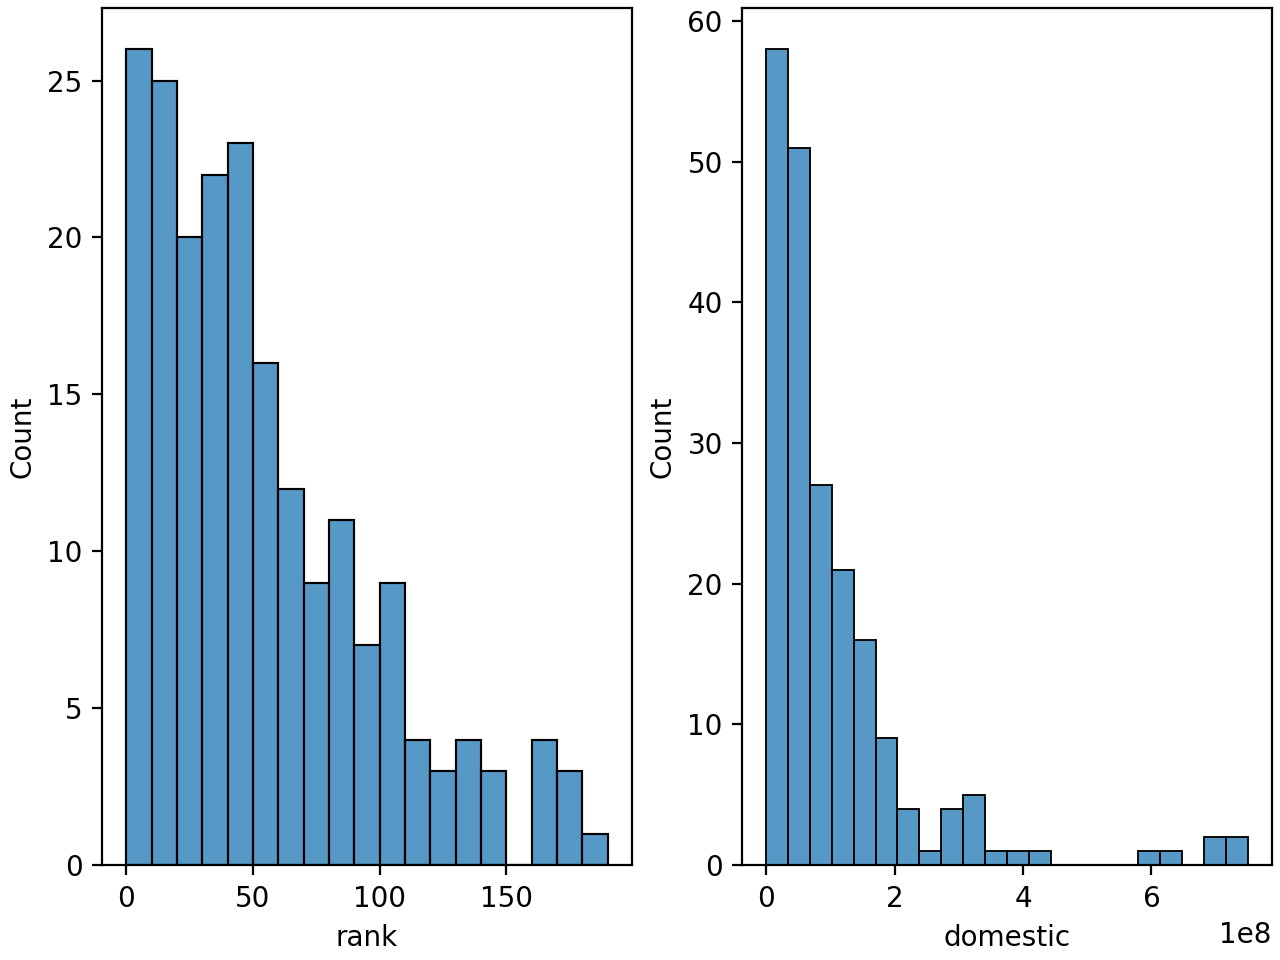

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
sns.histplot(x='rank', data=oscars_box_office, bins=range(0,200,10), ax=ax1)
sns.histplot(x='domestic', data=oscars_box_office, ax=ax2)
plt.show()

<IPython.core.display.Javascript object>


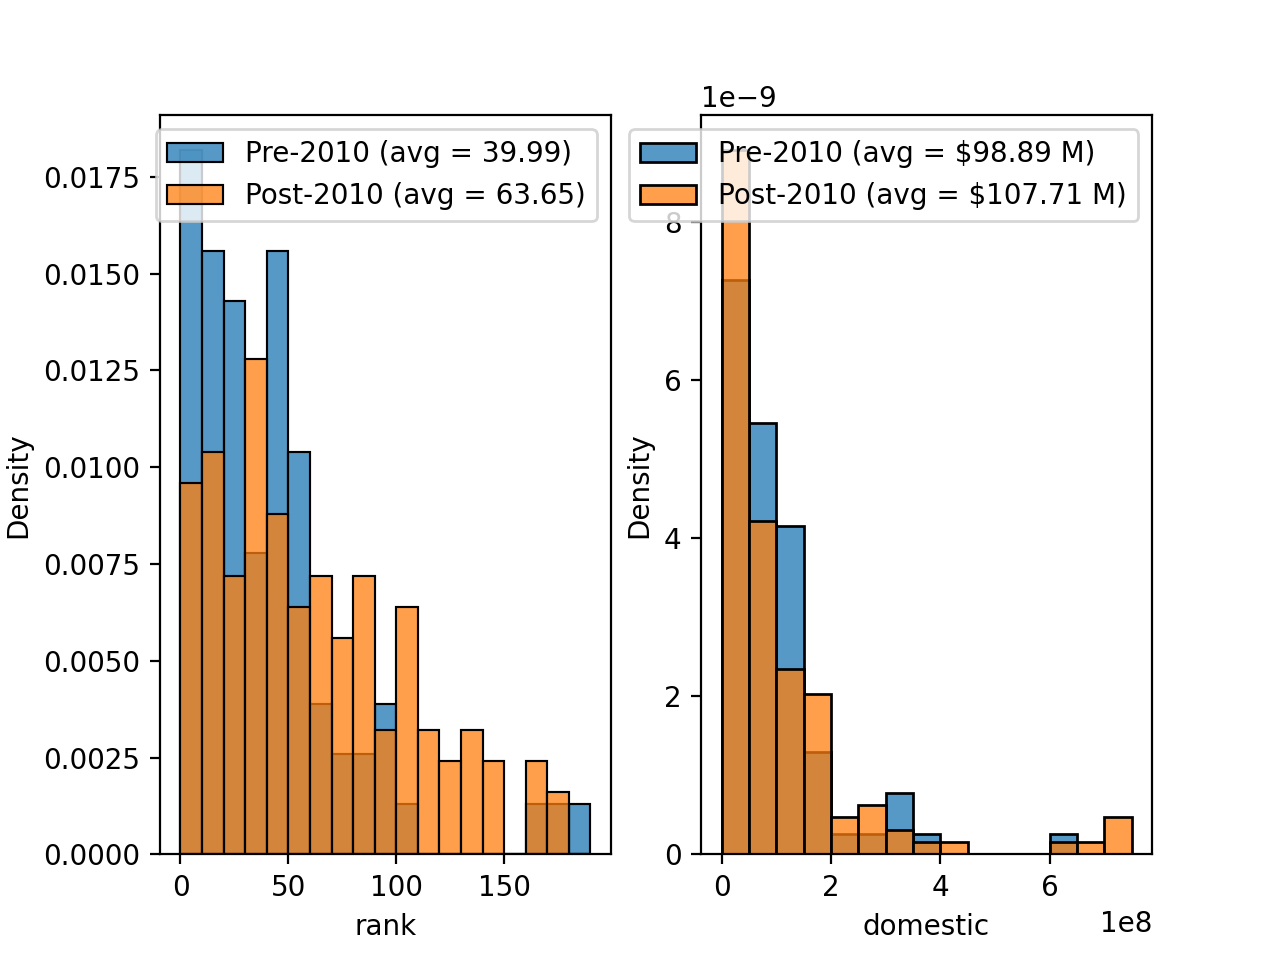

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

In [304]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False)
year_mask = (oscars_box_office['year_ceremony'] < 2010)
sns.histplot(x='rank', data=oscars_box_office[year_mask], bins=range(0,200,10), 
             ax=ax1, color=sns.color_palette()[0], stat='density',
             label='Pre-2010 (avg = {:.2f})'.format(oscars_box_office[year_mask].mean(numeric_only=True)['rank']))
sns.histplot(x='rank', data=oscars_box_office[~year_mask], bins=range(0,200,10), 
             ax=ax1, color=sns.color_palette()[1], stat='density',
             label='Post-2010 (avg = {:.2f})'.format(oscars_box_office[~year_mask].mean(numeric_only=True)['rank']))
ax1.legend()
sns.histplot(x='domestic', data=oscars_box_office[year_mask], ax=ax2, bins=np.arange(0,8E8,0.5E8),
             color=sns.color_palette()[0], stat='density',
             label='Pre-2010 (avg = ${:.2f} M)'.format(oscars_box_office[year_mask].mean(numeric_only=True)['domestic']/1E6))
sns.histplot(x='domestic', data=oscars_box_office[~year_mask], ax=ax2, bins=np.arange(0,8E8,0.5E8),
             color=sns.color_palette()[1], stat='density',
             label='Post-2010 (avg = ${:.2f} M)'.format(oscars_box_office[~year_mask].mean(numeric_only=True)['domestic']/1E6))
ax2.legend()
plt.show()

The above plot shows the box office rank and domestic box office earnings for the Best Picture nominees, separated into the pre- and post-2010 eras. The mean rank *decreases* for the post-2010 era. As would be expected given inflation and the rising cost of an individual movie ticket, the average domestic box office is higher in the post-2010 era. A more careful treatment of inflation would be needed to use pure box office dollars as the comparison. However, rank can be used since it is just a comparison of the movies of one year to each other. When looking at rank, the average Best Picture nominee is less popular now than it was before 2010. As shown below this applies to the median as well as the mean rank printed above.

In [317]:
print(oscars_box_office[year_mask].median(numeric_only=True)['rank'])
print(oscars_box_office[~year_mask].median(numeric_only=True)['rank'])

32.0
52.0


<IPython.core.display.Javascript object>


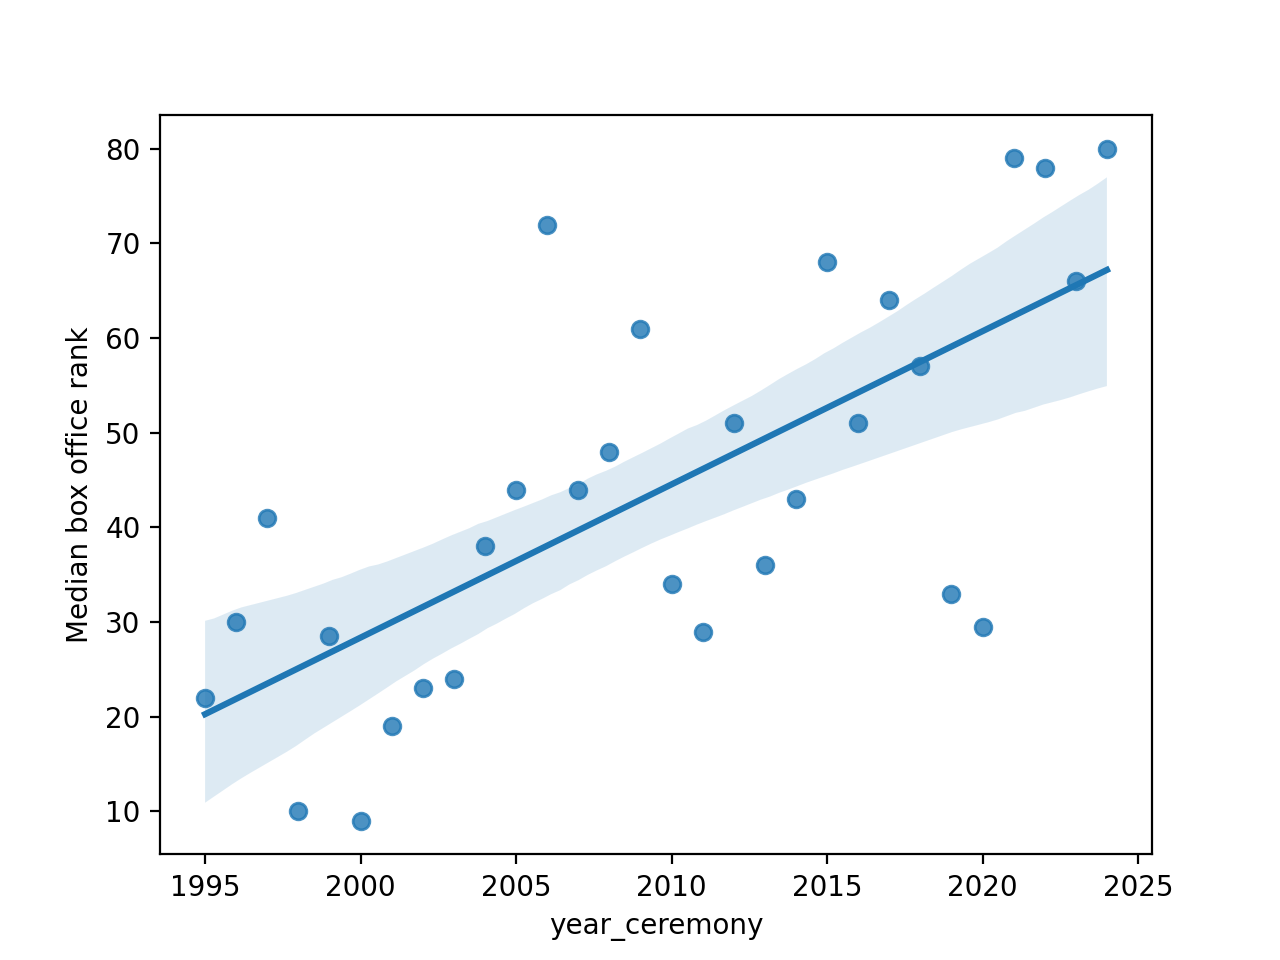

In [329]:
tmp = oscars_box_office.groupby('year_ceremony').median(numeric_only=True)['rank']
plt.figure()
sns.regplot(x=tmp.index, y=tmp.values)
plt.ylabel('Median box office rank')
plt.show()

As seen in the plot of median box office rank vs year, the median Best Picture nominees tend to be lower ranks over time.

I will run a test to determine whether the distributions are the same pre- and post-2010. To do this, I will perform a two-sample t-test, which compares two distributions. The null hypothesis is that there is no difference between the distributions.

In [305]:
from scipy import stats

In [347]:
pre2010 = oscars_box_office[year_mask].dropna()['rank']
post2010 = oscars_box_office[~year_mask].dropna()['rank']
t_stat, p_val = stats.ttest_ind(pre2010, post2010)

In [348]:
p_val

0.00026774932039851123

Given the return p_val is (much) less than 0.05, I can reject the null hypothesis and conclude that indeed the rank distributions are different. The post-2010 ranks are not just a continuation of the pre-2010 behavior, they actually changed.

However, the changes are not monotonic - median box office rank doesn't only increase and Nielsen rating for the Oscars does not only decrease. I'll look for smaller effects within these larger trends.

### Relationship between Box Office and Viewership<a class="anchor" id="section4"></a>

Now having a good handle on both the TV rating/viewership numbers as well as the box office numbers, I'll look at any relationships between the two.

First, I just want to look at them plotted together.

<IPython.core.display.Javascript object>


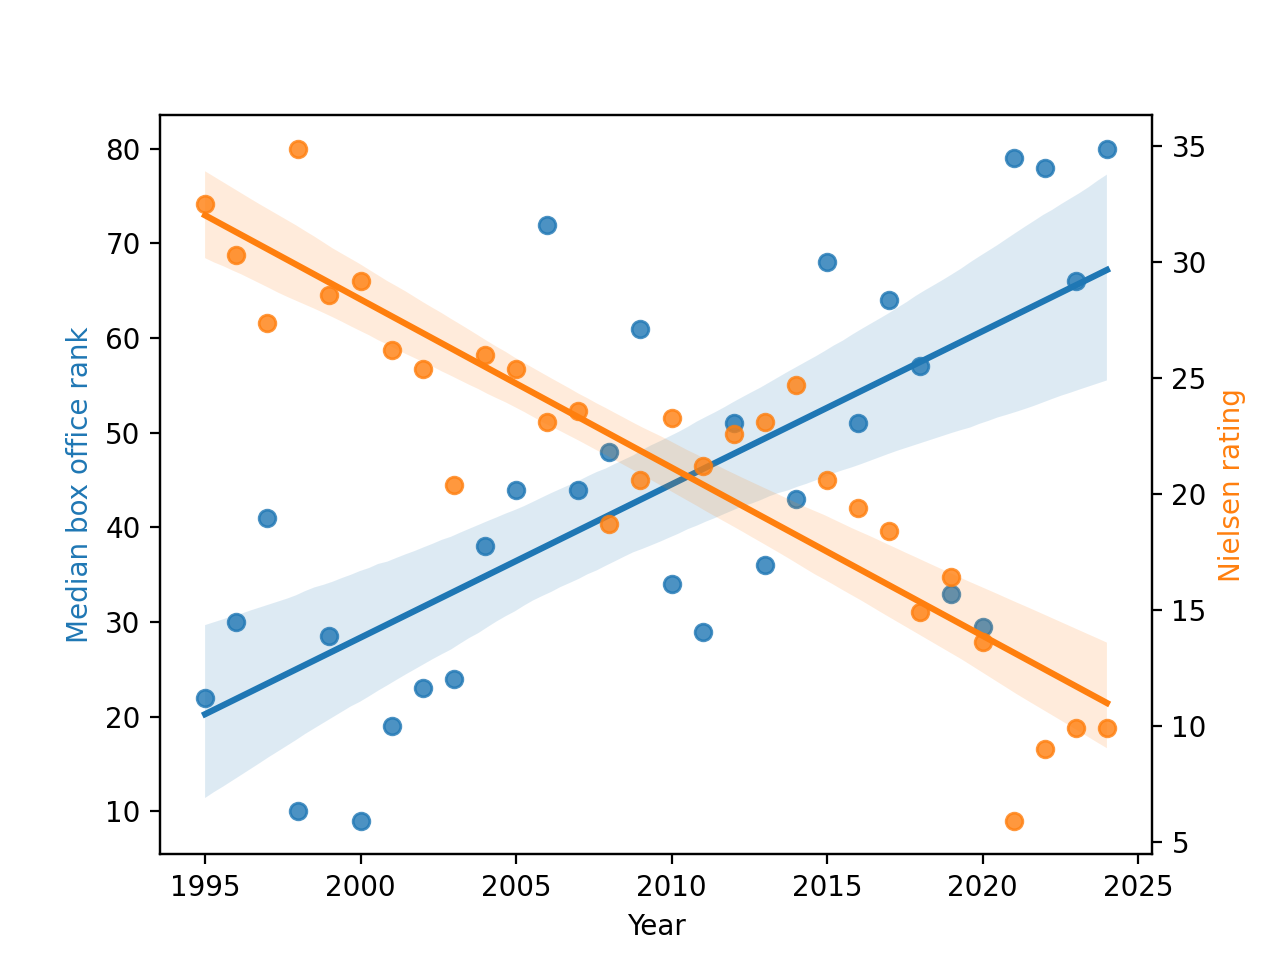

In [397]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.regplot(x=tmp.index, y=tmp.values, label='Median nominee box office rank', 
            ax=ax1, color=sns.color_palette()[0])
sns.regplot(x='Year', y = 'Rating', data = ratings_data[ratings_data.Category=='Oscars'], 
            label='Nielsen rating', ax=ax2, color=sns.color_palette()[1])
ax1.set_xlabel('Year')
ax1.set_ylabel('Median box office rank', color=sns.color_palette()[0])
ax2.set_ylabel('Nielsen rating', color=sns.color_palette()[1])
#plt.legend()
plt.show()

The plots show the overall trends: Nielsen rating for the Oscars is dropping, and Best Picture nominees are getting less popular at the box office. However, there are some periods where the TV rating is above the trendline and there are some periods where the box office rank is below the trendline.

<IPython.core.display.Javascript object>


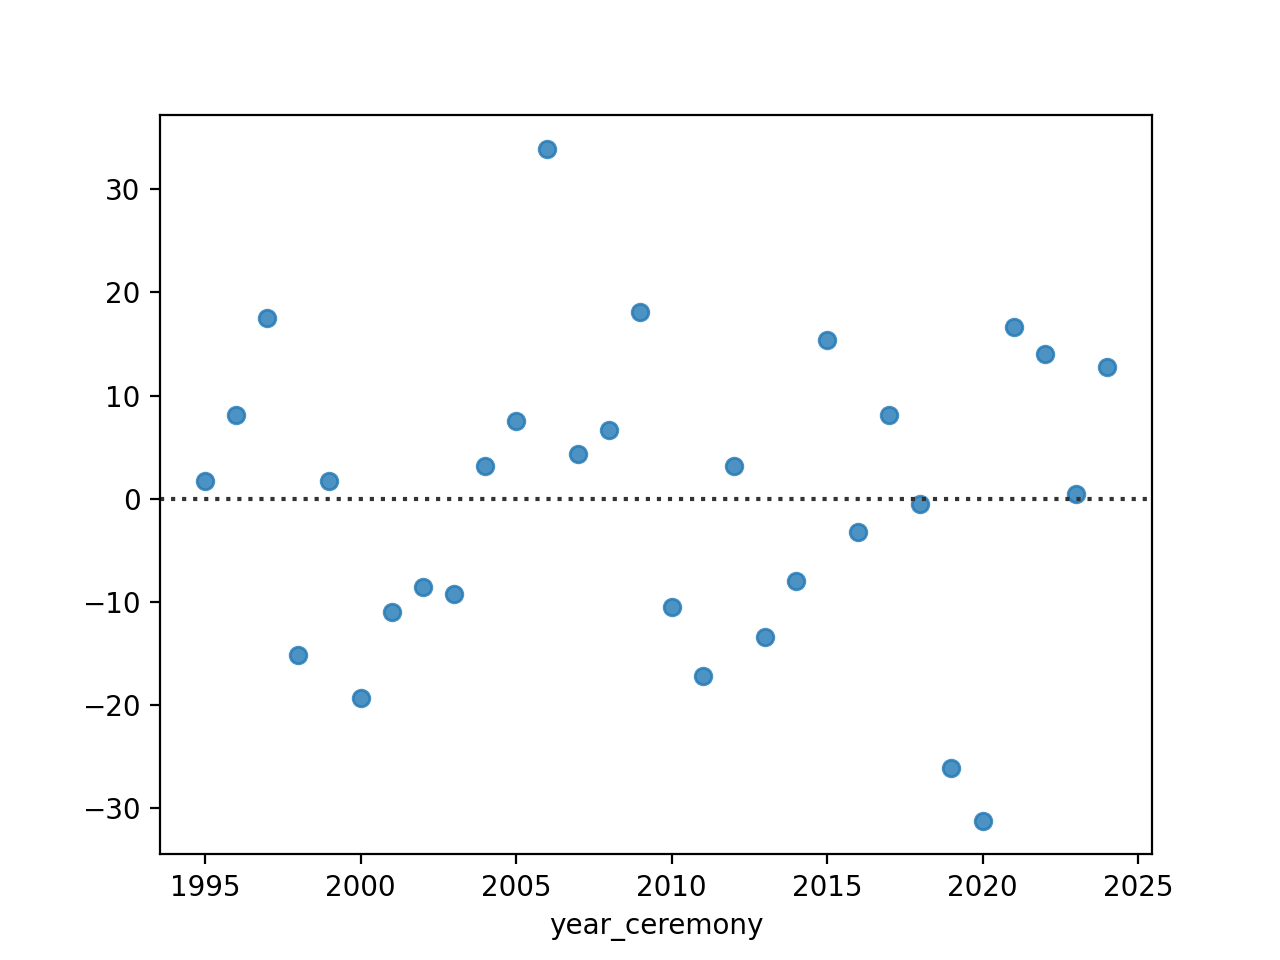

In [400]:
plt.figure()
rank_resid = sns.residplot(x=tmp.index, y=tmp.values, label='Median nominee box office rank')
rank_plot = rank_resid.collections[0]
rank_x = rank_plot.get_offsets()[:, 0]
rank_y = rank_plot.get_offsets()[:, 1]
plt.show()

<IPython.core.display.Javascript object>


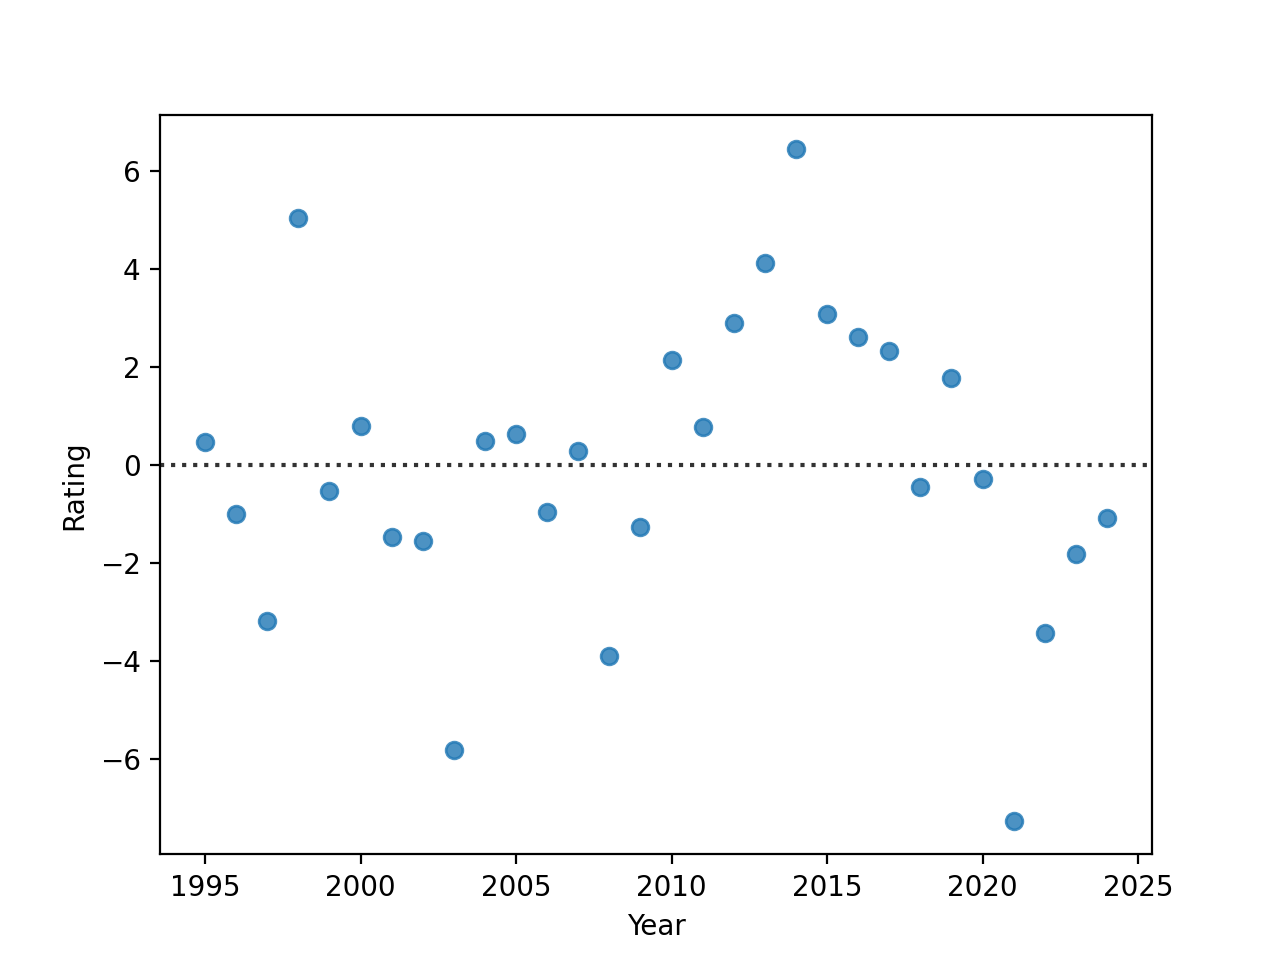

In [401]:
plt.figure()
rating_resid = sns.residplot(x='Year', y = 'Rating',
                data = ratings_data[ratings_data.Category=='Oscars'], label='Nielsen rating')
rat_plot = rating_resid.collections[0]
rat_x = rat_plot.get_offsets()[:, 0]
rat_y = rat_plot.get_offsets()[:, 1]
plt.show()

<IPython.core.display.Javascript object>


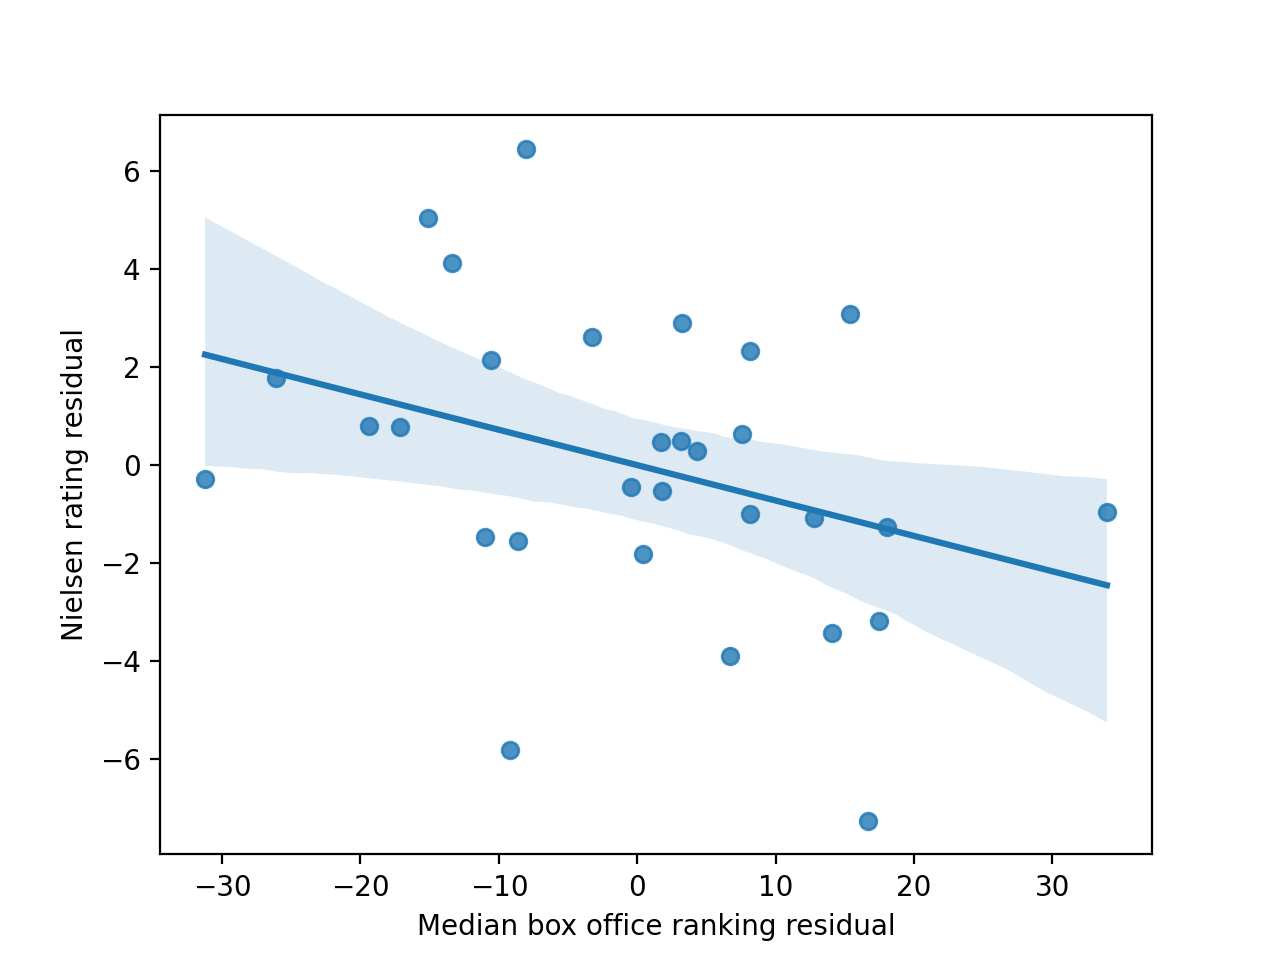

In [405]:
plt.figure()
sns.regplot(x=rank_y, y=rat_y, order=1)
plt.xlabel('Median box office ranking residual')
plt.ylabel('Nielsen rating residual')
plt.show()

I calculated the residuals - the difference between each individual point in the box office rank and Nielsen rating plot and the average trendline. This residual value tells whether a specific year was above/below the trendline.

Looking at the rating residual plot above, the years 2010-2017, after the rule change, do show that the ratings were higher than you would expect just simply based on the trendline.

It's possible that the two residuals are correlated - when films are slightly more popular (lower rank) than the overall trend, there is a higher Nielsen rating. The above plot shows the residuals plotted against each other. There is indeed a negative correlation between the two.

In [407]:
res = stats.linregress(rank_y, rat_y)

In [408]:
res

LinregressResult(slope=-0.07225286586308259, intercept=3.793167267058247e-13, rvalue=-0.3501164795800068, pvalue=0.05786599056536521, stderr=0.0365314483152502, intercept_stderr=0.5225061594635892)

The slope of this line is -0.072 $\pm$ 0.37. The $R^2$ value is 0.122, and the p-value is 0.058. The $R^2$ value tells us that any correlation is weak. Given that the p-value is greater than 0.05, we cannot reject the null hypothesis, that the slope is zero and there is no correlation between these points.

### Conclusion<a class="anchor" id="conclusion"></a>

The analysis in this notebook looked at the trends of TV ratings for awards programs, in particular the Academy Awards. I also investigated how the rules changes implemented in the Best Picture nomination process affected the nominees in the years since 2010.

The overall trends are powerful - TV ratings are decreasing over time. Additionally, the rules change does not seem to have led to many more blockbusters at the top of the annual box office rankings being nominated for Best Picture. Instead, the additional films seem to come from the moderately popular films.

Even if the rules change was made to prevent a *Dark Knight*-esque snub from happening again, it does not seem that the change has led to a constant stream of the top-earners being nominated.

#### Next Steps<a class="anchor" id="next"></a>

There is some indication that maybe the rules change led to a period of better ratings than the trendline suggests. This is not entireley explained by the median box office performance however. But simply looking at the median is a crude way of going about this analysis. To investigate further, I might want to look at not just the median but the top/bottom or how many top-20 films there are, or some other way of looking more finely at what the slate of nominees looks like from year to year and how that correlates.

I'd also like to try some discontinuity analyses centered on the 2010 ceremony to be sure whether there are measurable changes or not.